In [22]:
import torch
import numpy as np
from typing import Tuple


class CusumMeanDetector():

    def __init__(self, t_warmup = 30, p_limit = 0.01) -> None:
        self._t_warmup = t_warmup
        self._p_limit = p_limit

        self._reset()



    def predict_next(self, y: torch.tensor) -> Tuple[float,bool]:
        self._update_data(y)

        if self.current_t == self._t_warmup:
            self._init_params()

        if self.current_t >= self._t_warmup:
            prob, is_changepoint = self._check_for_changepoint()
            if is_changepoint:
                self._reset()

            return (1-prob), is_changepoint

        else:
            return 0, False


    def _reset(self) -> None:
        self.current_t = torch.zeros(1)

        self.current_obs = []

        self.current_mean = None
        self.current_std = None


    def _update_data(self, y: torch.tensor) -> None:
        self.current_t += 1
        #print("b:",str(y)," a:",str(y.reshape(1)))
        self.current_obs.append(y.reshape(1))



    def _init_params(self) -> None:
        self.current_mean = torch.mean(torch.concat(self.current_obs))
        self.current_std = torch.std(torch.concat(self.current_obs))


    def _check_for_changepoint(self) -> Tuple[float,bool]:
        standardized_sum = torch.sum(torch.concat(self.current_obs) - self.current_mean)/(self.current_std * self.current_t**0.5)
        prob = float(self._get_prob(standardized_sum).detach().numpy())

        return prob, prob < self._p_limit


    def _get_prob(self, y: torch.tensor) -> bool:
        p = torch.distributions.normal.Normal(0,1).cdf(torch.abs(y))
        prob = 2*(1 - p)

        return prob

C:\Users\tikyn\AppData\Local\Temp\ipykernel_17848\2381946499.py:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  prob = float(self._get_prob(standardized_sum).detach().numpy())


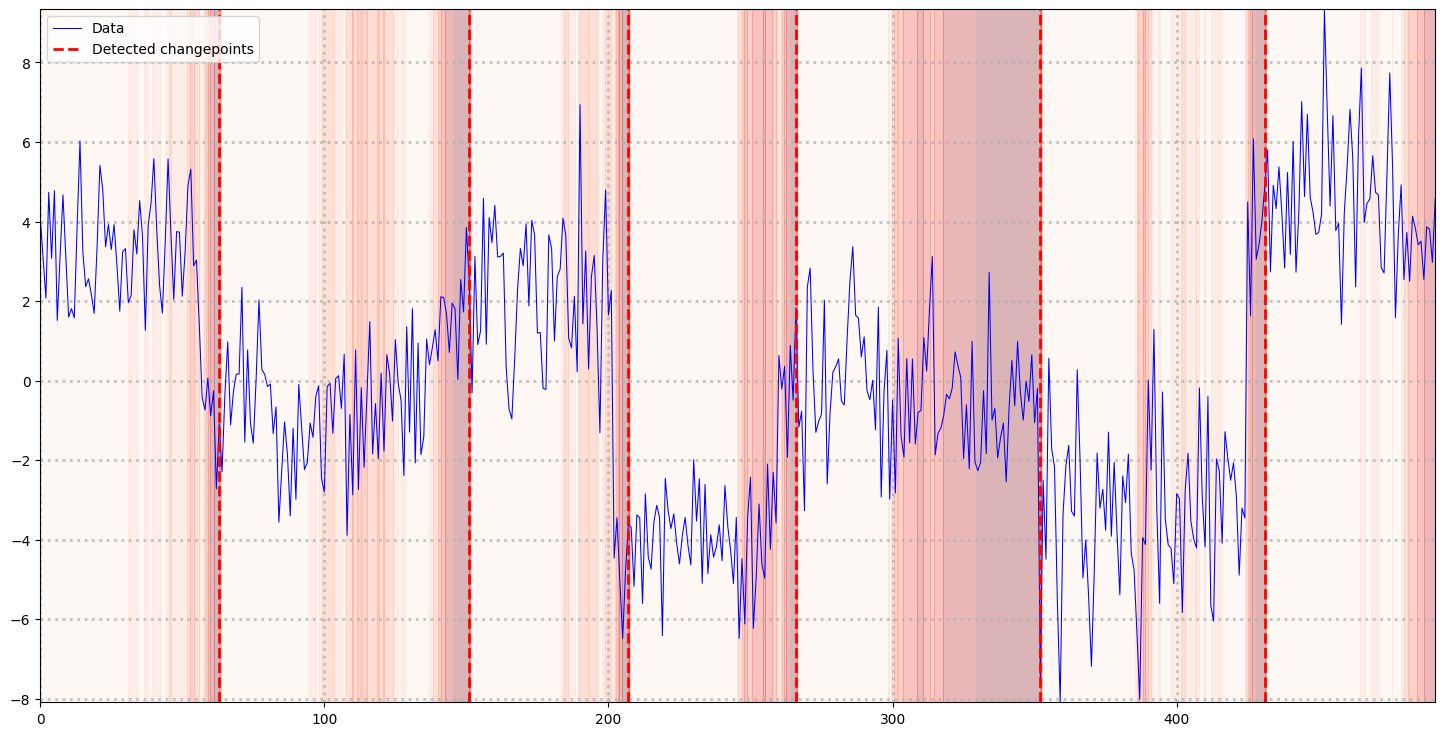

In [2]:
import matplotlib.pyplot as plt

import pandas as pd

import pandas as pd
#df=pd.read_csv("/content/test.csv", header=None, squeeze=True)

#y = torch.tensor(df.T.values)
np.random.seed(456)
torch.manual_seed(456)

segment_lengths = [np.random.randint(30,100) for _ in range(7)]


y = torch.concat([torch.normal(torch.zeros(seg_len)+np.random.uniform(-5,5),np.random.uniform()+1) for seg_len in segment_lengths])

test = CusumMeanDetector()
#outs = [test.predict_next(y[i][0]) for i in range(len(y))]

outs = [test.predict_next(y[i]) for i in range(len(y))]

cps = np.where(list(map(lambda x: x[1], outs)))[0]
probs = np.array(list(map(lambda x: x[0], outs)))

X, Y = np.meshgrid(np.arange(len(y)),np.linspace(torch.min(y).detach().numpy(),torch.max(y).detach().numpy()))
Z = probs[X]


plt.figure(figsize=(18,9))
plt.contourf(X,Y,Z,alpha=0.3,cmap="Reds")
plt.plot(np.arange(len(y)),y.detach().numpy(),lw=0.75,label="Data",color="blue")


plt.axvline(cps[0], color="red", linestyle="dashed",label="Detected changepoints",lw=2)
[plt.axvline(cp, color="red", linestyle="dashed",lw=2) for cp in cps[1:]]

plt.grid(alpha=0.75, linestyle="dotted",lw=2)

plt.legend()
plt.show()

In [16]:
def GraphZscore(y, threshold,windowmax):
  plt.figure(figsize=(18,9))
  plt.plot(np.arange(len(y)),y,lw=0.75,label="Data",color="blue")
  """
  # 1.1 definisco i z standardized value ad ogni finestra di 100ms con step = 1 e li stampo
  i=0
  zscore=[]
  windows_range=[]
  while (i+100)<len(y):
    windows_range.append([i,i+100])
    c_win = y[i:i+100]
    c_mean = np.mean(c_win)
    c_std = np.std(c_win)
    c_zscore = []
    for j in c_win:
      c_zscore.append((j-c_mean)/c_std)
    zscore.append(c_zscore)
    i=i+1
  #piccolo check per controllare che se mi avanza una finestra finale da 70 a 100, creo una mini finestra da 30 finale
  if i+100 <len(y)-1:
    windows_range.append([i,len(y)])
    c_win = y[i:len(y)]
    c_mean = np.mean(c_win)
    c_std = np.std(c_std)
    c_zscore = []
    for j in c_win:
      c_zscore.append((j-c_mean)/c_std)
    zscore.append(c_zscore)
  plt.figure(figsize=(18,9))
  for idx,j in enumerate(zscore):
    plt.plot(np.arange(windows_range[idx][0],windows_range[idx][1]),j)

  # 1.2 applico cusum su finestra temporale che cambia ogni 100ms
  cusum_1=[]
  for j in zscore:
    sh_res=[0]
    sl_res=[0]
    sh=0
    sl=0
    w=0.5
    for idx,k in enumerate(j):
      if idx==0:
        continue
      sh=max(0, sh+k-w)
      sl=max(0, sl-k-w)
      sh_res.append(sh)
      sl_res.append(sl)
    cusum_1.append([sh_res,sl_res])

  plt.figure(figsize=(18,9))
  for idx,j in enumerate(cusum_1):

    plt.plot(np.arange(windows_range[idx][0],windows_range[idx][1]),j[0],'r')
    plt.plot(np.arange(windows_range[idx][0],windows_range[idx][1]),j[1],'b')
  """
  # 2.1 applico cusum dove aggiorno la media e varianza se ce stato un changepoint

  c2_sh_res=[0]
  c2_sl_res=[0]
  c2_z_res=[]
  c2_change=[]
  c2_mean = np.mean(y[0:windowmax])
  c2_std = np.std(y[0:windowmax])
  windowrange=[[0,windowmax]]
  print("Std init:",c2_std)
  c2_sh = 0
  c2_sl = 0
  w=0.5
  for idx,j in enumerate(y):

    # salto perche il sh e sl si fa considerando il valore precedente e in -1 non ho valori
    if idx == 0:
      continue
    c2_z = (j-c2_mean)/c2_std
    c2_z_res.append(c2_z)
    c2_sh = max(0, c2_sh+c2_z-w)
    c2_sl = max(0, c2_sl-c2_z-w)
    c2_sh_res.append(c2_sh)
    c2_sl_res.append(c2_sl)
    #print(c2_sh," ",c2_std," ",idx)
    smul = 0.5
    
    if c2_sh > threshold or c2_sl > threshold:
      
      c2_change.append([idx])
      c2_sh = 0
      c2_sl = 0
   
      if idx+100 >= len(y):
        windowrange.append([idx,len(y)])
        c2_mean = np.mean(y[idx:len(y)])
        c2_std = np.std(y[idx:len(y)])

      else:
        #print("else")
        windowrange.append([idx,idx+windowmax])
        c2_mean = np.mean(y[idx:idx+windowmax])
        c2_std = np.std(y[idx:idx+windowmax])
      print("std:",c2_std)



  for j in windowrange:
    plt.axvline(x = j[0], color = 'g',alpha=0.2)
    plt.axvline(x = j[1], color = 'r',alpha=0.2)
   
  plt.figure(figsize=(18,9))
  plt.plot(np.arange(len(y)-1),c2_z_res,'g')

  plt.figure(figsize=(18,9))
  plt.plot(np.arange(len(y)),c2_sh_res,color="green")
  for j in c2_change:
    plt.axvline(x = j, color = 'b',alpha=0.2)

  plt.plot(np.arange(len(y)),c2_sl_res,color="red")
  print("z")
  print(c2_z_res)
  print("c2_sh")
  print(c2_sh_res)
  print("c2_sl")
  print(c2_sl_res)
  plt.legend()
  plt.show()

  return c2_change

In [55]:
def ChangePointDynWin(y, threshold,windowmax,w):
  plt.figure(figsize=(18,9))
  plt.plot(np.arange(len(y)),y,lw=0.75,label="Data",color="blue")


  c2_sh_res=[0]
  c2_sl_res=[0]
  c2_z_res=[]
  c2_change=[]
  c2_mean = np.mean(y[0:windowmax])
  c2_std = np.std(y[0:windowmax])
  windowrange=[[0,windowmax]]
  print("Std init:",c2_std)
  c2_sh = 0
  c2_sl = 0
 
  updateWin=0
  for idx,j in enumerate(y):

    # salto perche il sh e sl si fa considerando il valore precedente e in -1 non ho valori
    if updateWin == 1:
      
      c2_sh = 0
      c2_sl = 0
   
      if idx+100 >= len(y):

        c2_mean = np.mean(y[idx:len(y)])
        c2_std = np.std(y[idx:len(y)])

      else:

        c2_mean = np.mean(y[idx:idx+windowmax])
        c2_std = np.std(y[idx:idx+windowmax])
      
    
      if c2_std > 1:
        c2_z_res.append(0)
        c2_sh_res.append(0)
        c2_sl_res.append(0)
        continue
      else:
        print("std:",c2_std)
        if idx+100 >= len(y):
          windowrange.append([idx,len(y)])
        else:
          windowrange.append([idx,idx+windowmax])

        updateWin = 0
      
    if idx == 0:
      continue
    c2_z = (j-c2_mean)/c2_std
    c2_z_res.append(c2_z)
    c2_sh = max(0, c2_sh+c2_z-w)
    c2_sl = max(0, c2_sl-c2_z-w)
    c2_sh_res.append(c2_sh)
    c2_sl_res.append(c2_sl)
    #print(c2_sh," ",c2_std," ",idx)

    
    if c2_sh > threshold or c2_sl > threshold:
      updateWin=1
      c2_change.append([idx])
      



  for j in windowrange:
    plt.axvline(x = j[0], color = 'g',alpha=0.2)
    plt.axvline(x = j[1], color = 'r',alpha=0.2)
   
  plt.figure(figsize=(18,9))
  plt.plot(np.arange(len(y)-1),c2_z_res,'g')

  plt.figure(figsize=(18,9))
  plt.plot(np.arange(len(y)),c2_sh_res,color="green")
  for j in c2_change:
    plt.axvline(x = j, color = 'b',alpha=0.2)

  plt.plot(np.arange(len(y)),c2_sl_res,color="red")
  print("z")
  print(c2_z_res)
  print("c2_sh")
  print(c2_sh_res)
  print("c2_sl")
  print(c2_sl_res)
  plt.legend()
  plt.show()

  return c2_change

11242.0


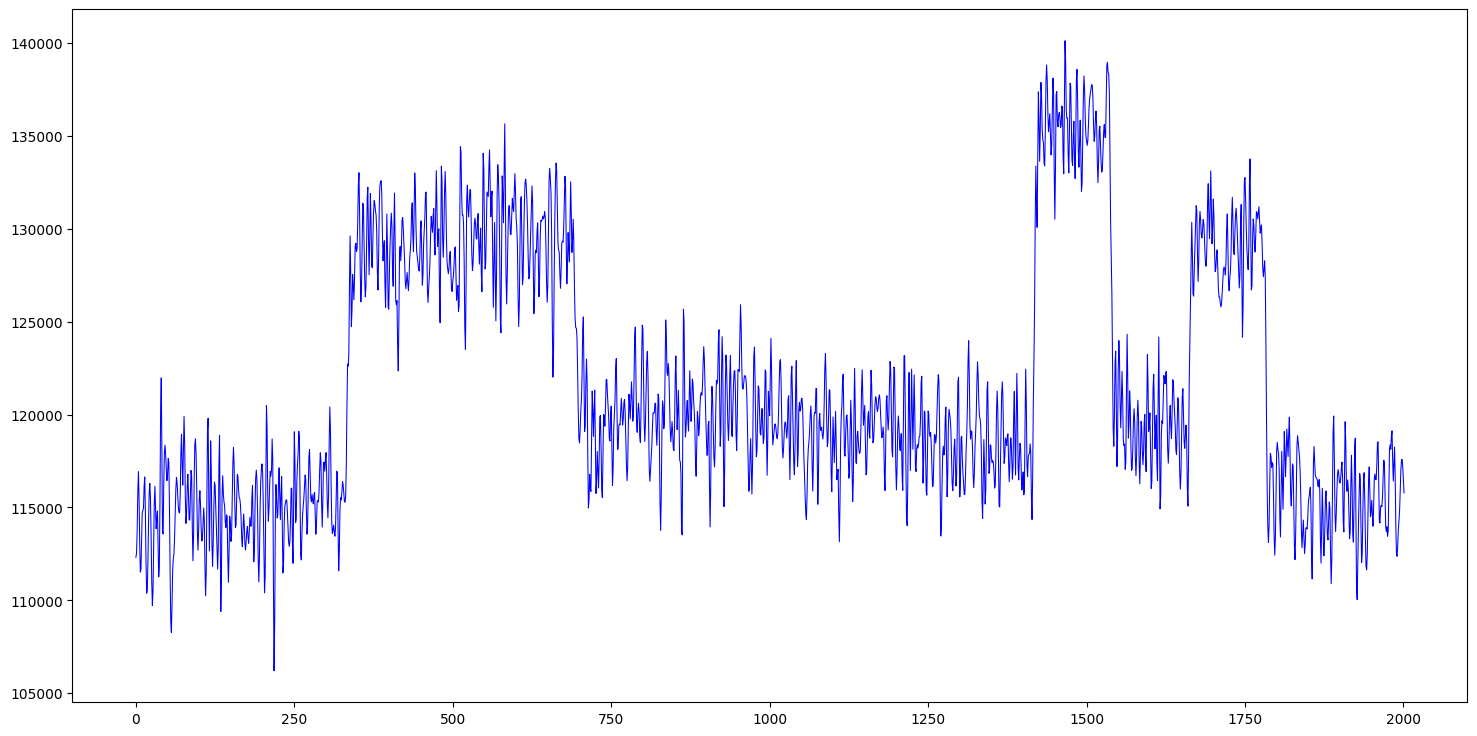

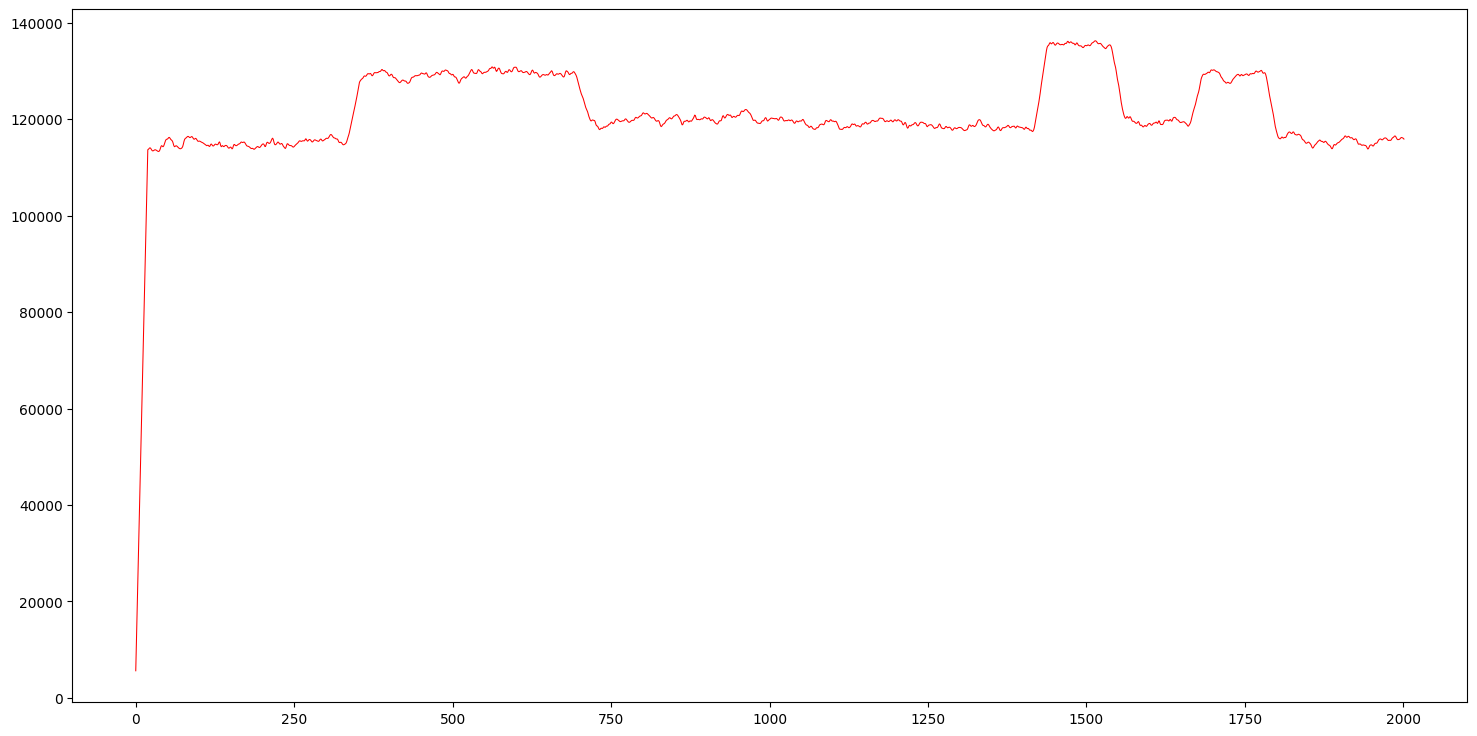

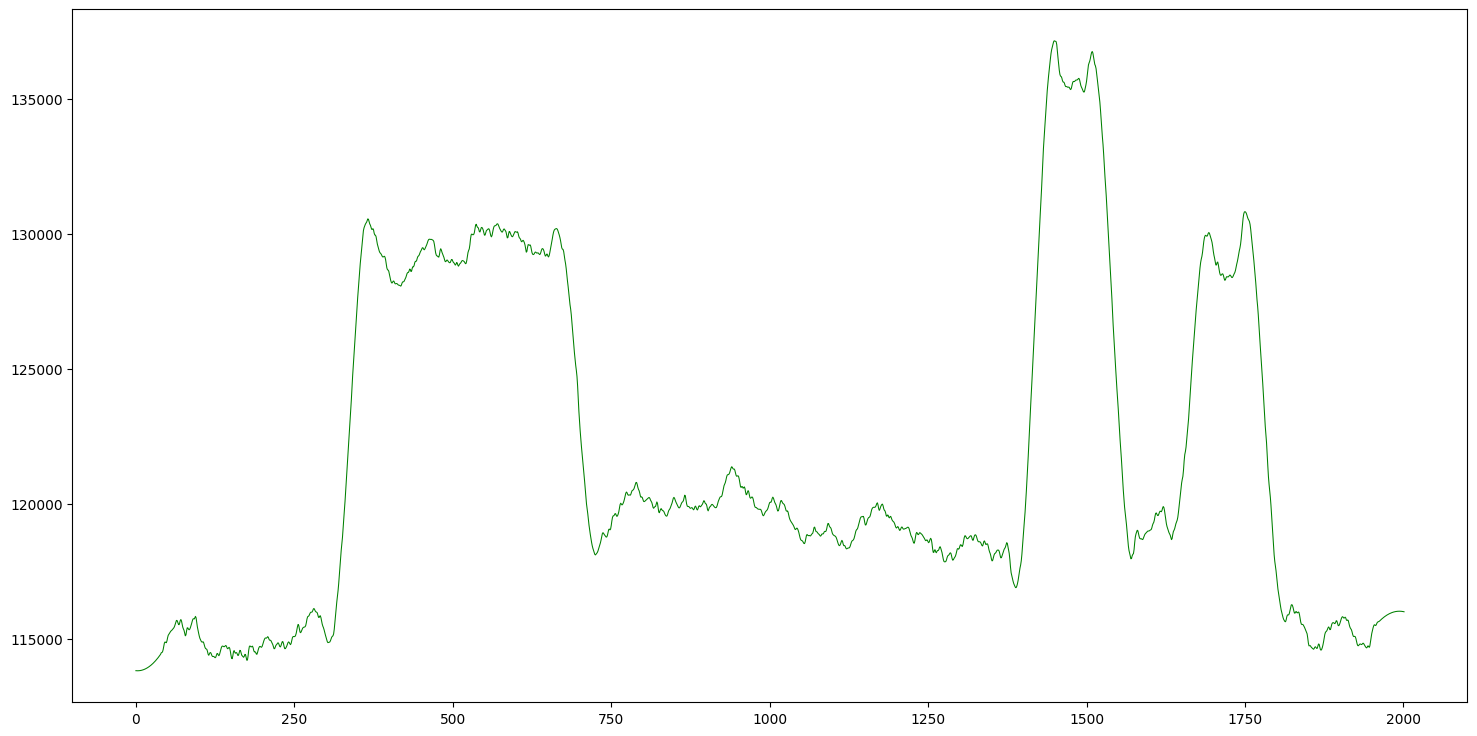

In [4]:
from scipy.signal import savgol_filter
from scipy.signal import lfilter
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
df=pd.read_csv("test.csv", header=None)
df=df.values.flatten() 
y2=savgol_filter(df, 80,2)
n = 20  # the larger n is, the smoother curve will be
b = [1.0 / n] * n
a = 1
y1 = lfilter(b, a, df)
plt.figure(figsize=(18,9))
plt.plot(np.arange(len(df)),df,lw=0.75,label="Data",color="blue")
plt.figure(figsize=(18,9))
plt.plot(np.arange(len(df)),y1,lw=0.75,label="Data",color="red")
plt.figure(figsize=(18,9))
plt.plot(np.arange(len(df)),y2,lw=0.75,label="Data",color="green")
print(y1[1])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Std init: 2569.1638698222423
std: 2034.3146266003203
std: 1982.638492010079
std: 1768.8899654868303
std: 1922.0762211733436
std: 2135.197065846616
std: 2092.9573598140983
z
[-0.8990862852823062, -0.4397928887572947, 0.36202439670162356, 0.813533159387228, 0.28028574138785034, -0.6733319039395039, -1.2922102941723583, -1.2299332234571025, -0.6383010516621725, -0.058345830626353, -0.0038533937505041862, 0.050639043125344625, 0.5021478058109491, 0.7006559687158269, -0.038884246027835564, -1.1014867651068874, -1.7359344230185558, -1.658088084624486, -1.074240546668963, -0.24128472585241686, 0.36980903054103054, 0.5644248765262049, 0.24914720603022245, -0.505962276392254, -1.4790415063181257, -1.992827339718986, -1.7009035707412243, -0.7901014115306085, 0.13627001535882133, 0.5021478058109491, 0.04285440928593765, -0.3814081349617424, -0.15565375361894018, -0.01163802758991116, -0.7044704392971318, -1.393410534084649, -1.187117737340364, 0.17908550147555968, 2.062966890612047, 2.77526088691

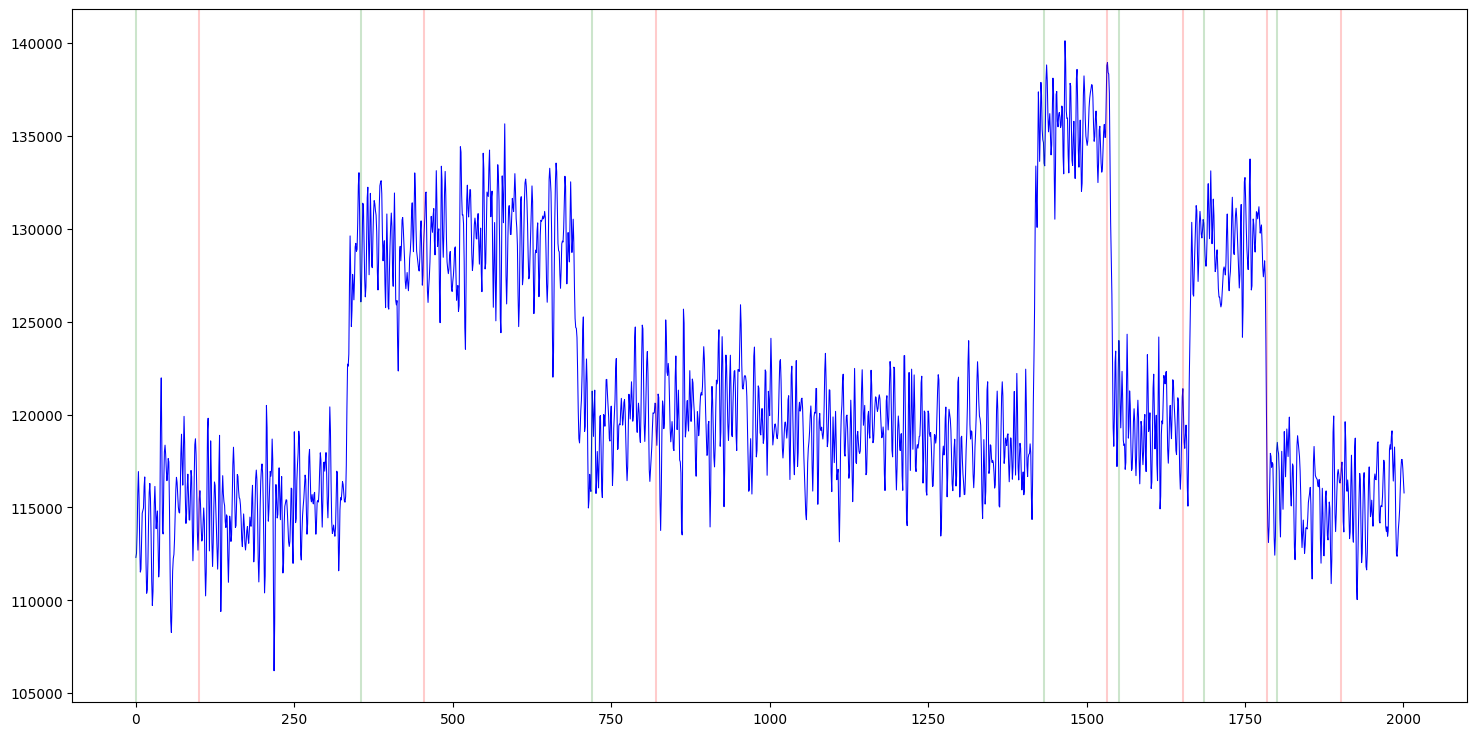

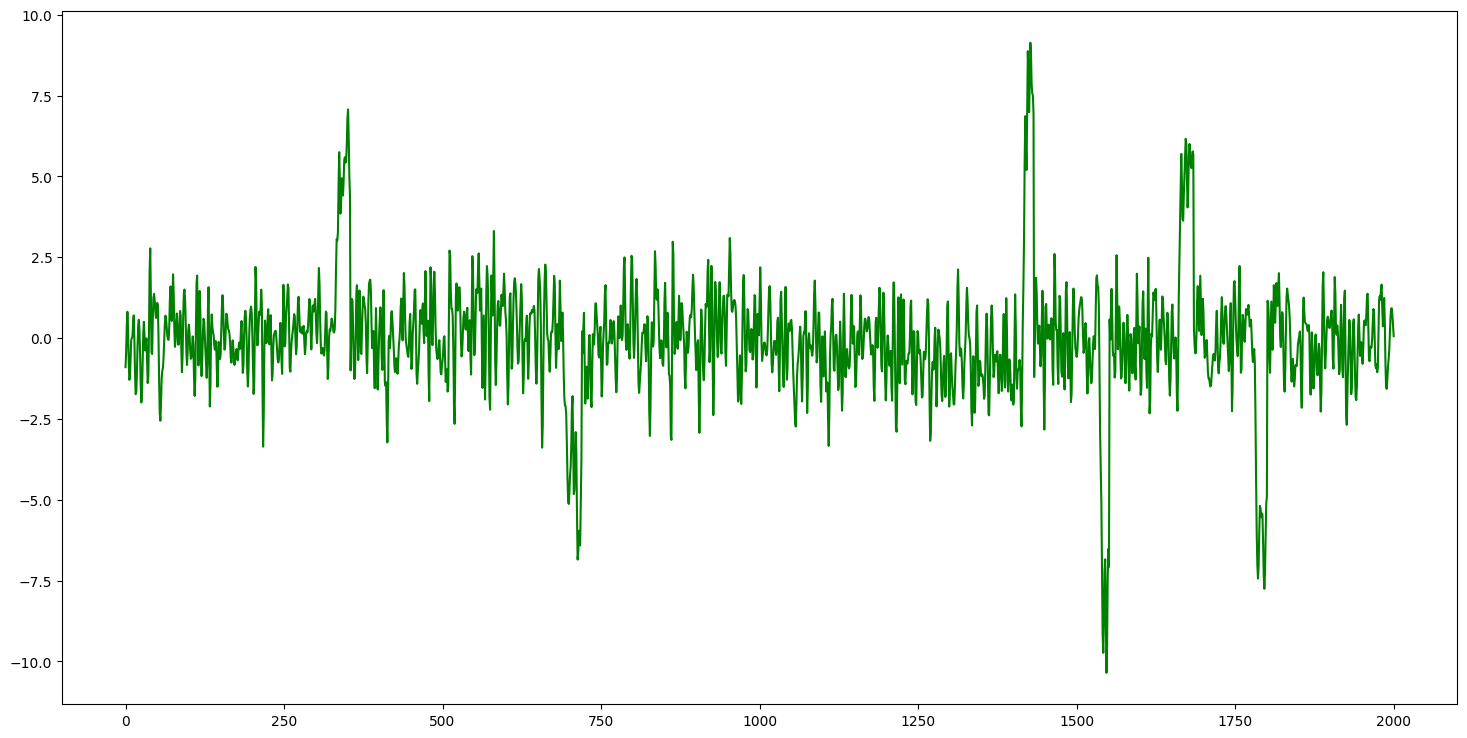

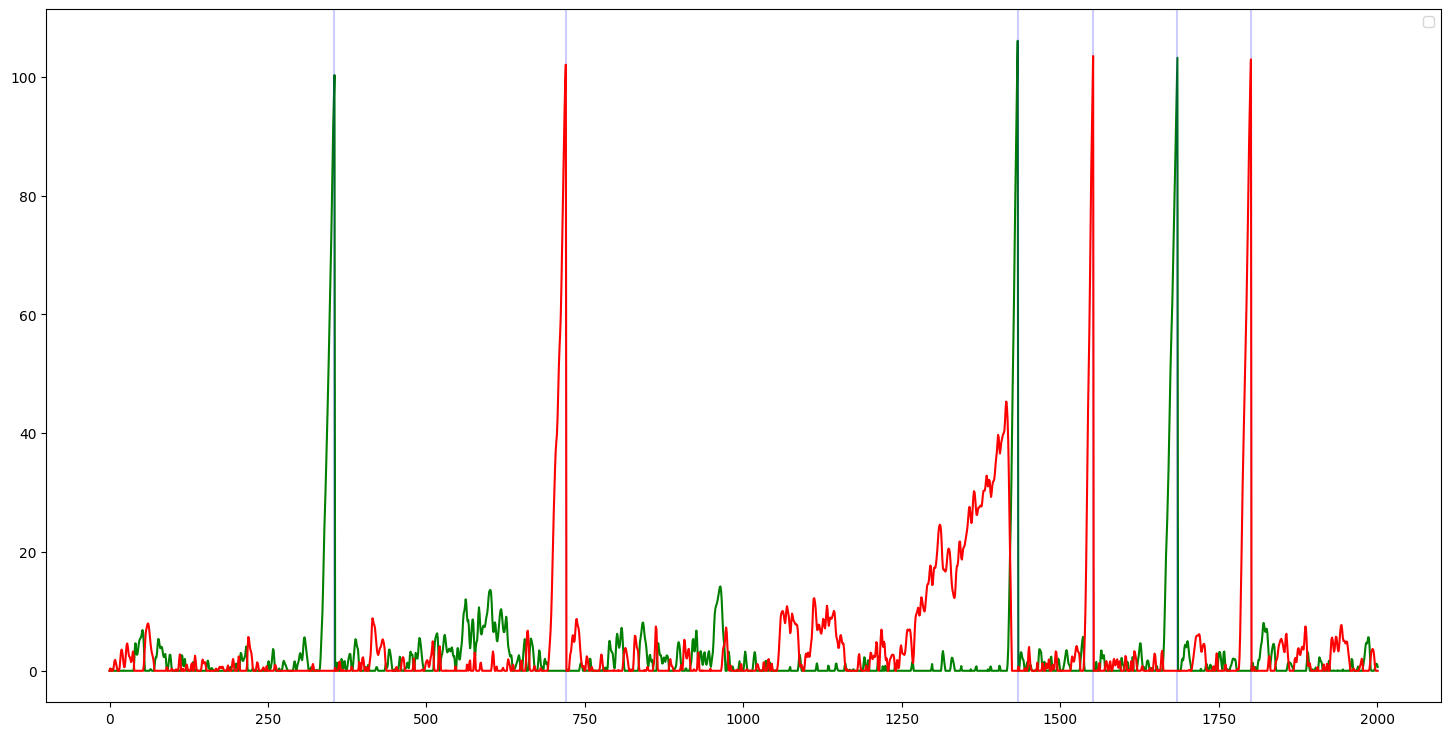

[[355], [720], [1433], [1552], [1685], [1801]]

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


df=pd.read_csv("test.csv", header=None)
df=df.values.flatten()

GraphZscore(df,100,100)


- da cambiare il limite 100 in qualcosa di piu dinamico in base ai valori dello z score
- applicare la funzione alla energia cinetica.
- salvare i changepoint e mostrarlo in un grafico con delle delte di dirac? o delle rette..
- subito sotto mostrare un grafico simile usando il groundtruth per vedere quanto sono simili

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Std init: 0.010215668238108558
std: 82.48103531947878
z
[-0.8107966906268262, -0.8090346913546833, -0.8046296931743263, -0.8059022482042073, -0.8102093575361119, -0.7814300360911123, -0.6649423064327801, -0.42482096117909207, -0.06243644420838149, 0.36543571237697137, 0.7328125606187531, 0.948070138365537, 1.0038667819833933, 0.919486594617442, 0.8027051984137527, 0.7844978726016099, 0.8382388504019666, 0.9558033573932749, 1.0992105203760116, 1.2092375860364868, 1.3089863226094618, 1.333262757025652, 1.2957713280683905, 1.1802624868945821, 1.0118936675564887, 0.835791629190657, 0.6612558124000635, 0.5166739832358984, 0.3558426052286381, 0.2887887440387578, 0.22486732599935377, 0.1860054531637588, 0.12286714591197374, 0.07881716410840285, 0.05072306460256973, 0.04847162108816495, 0.021356410066855753, 0.007651971283522607, 0.011567525221617815, -0.001060136228739262, -0.032188790036596145, -0.06605833160111953, -0.10452864904290486, -0.19155183531707065, -0.28239268668087925, -0.3982930

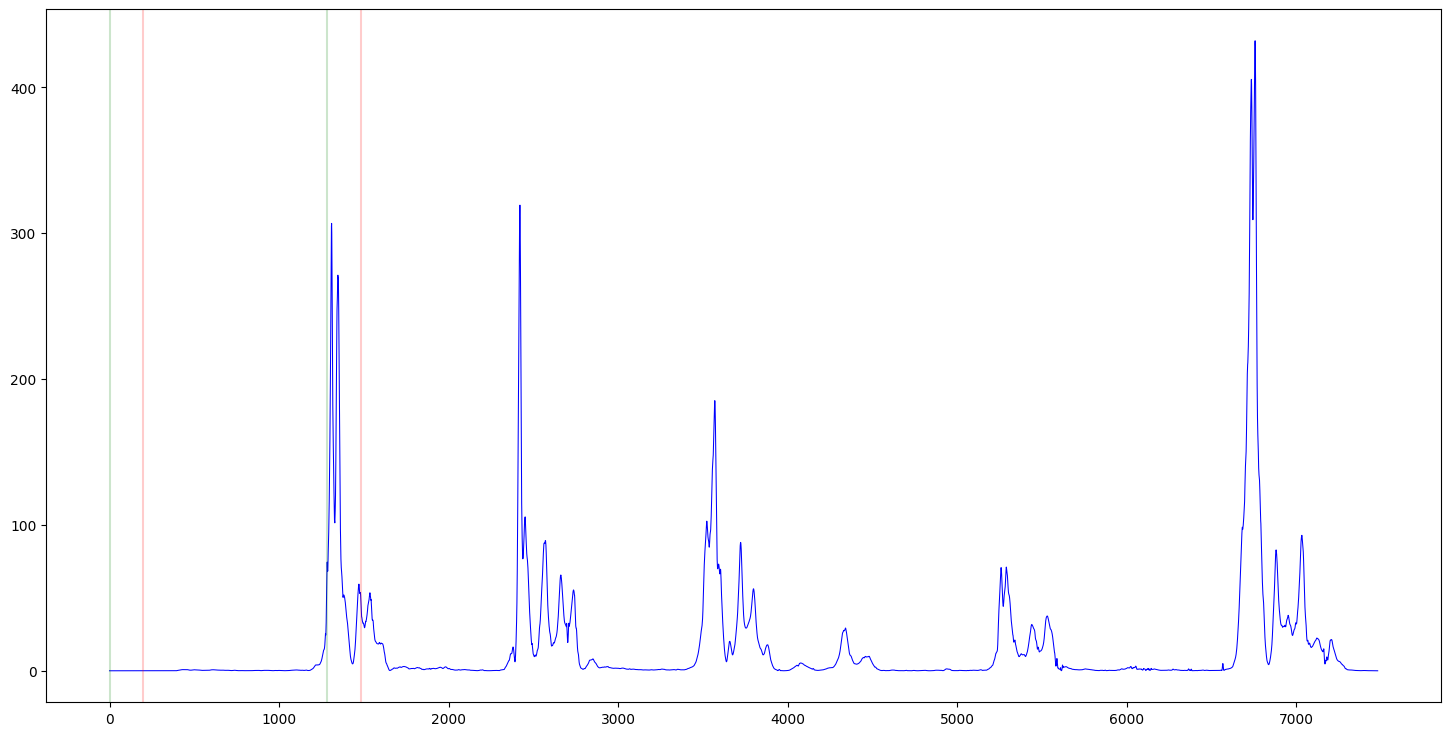

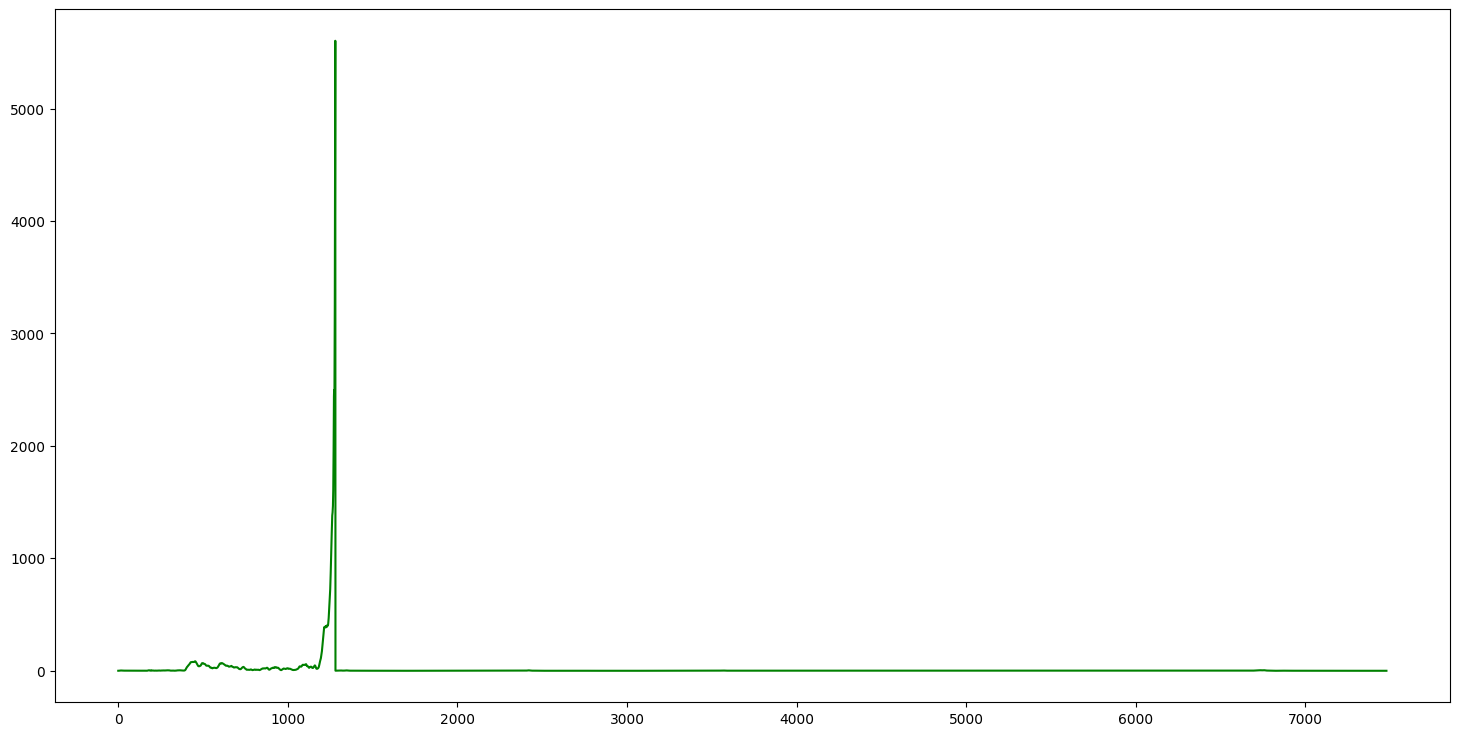

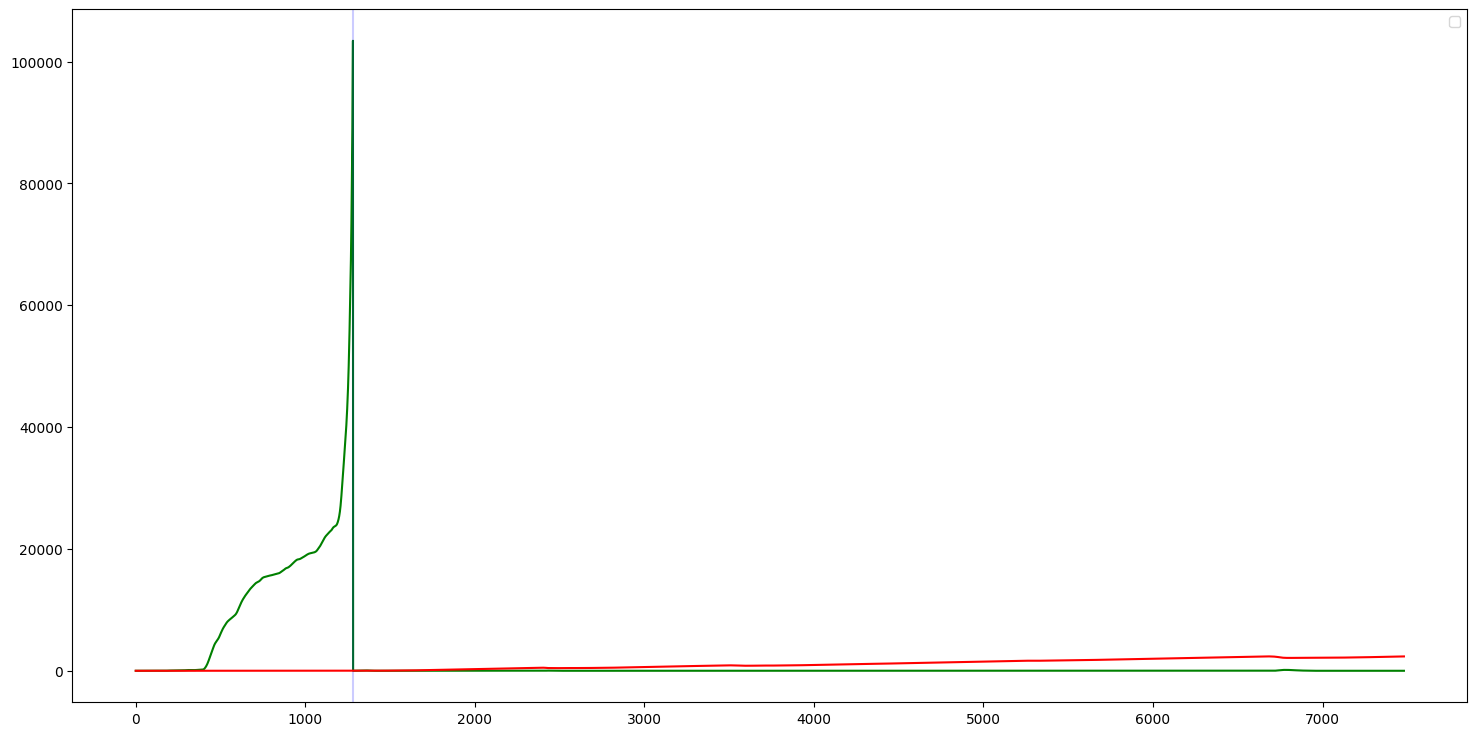

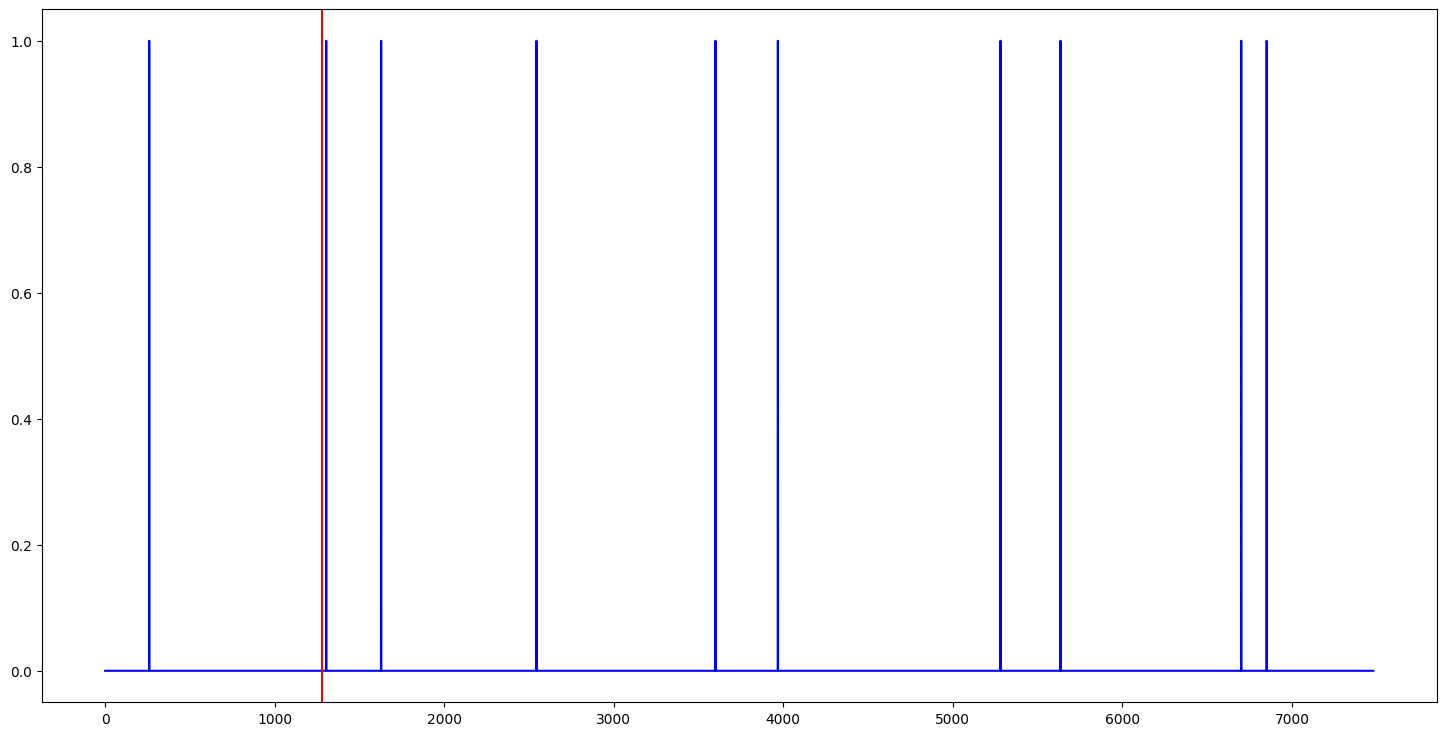

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


df=pd.read_csv("2016-03-22_t024_only_chest.txt",sep=' ', header=None)
df=df.iloc[:,1].values
cp = GraphZscore(df,100000,200)

gt=pd.read_csv("GA_single_22-03-2016_t024_location_ground_truth.txt", header=None)
gt=gt.values.flatten()

# determino la posizione relativa dei groundtruth per poi allungare il array
#calcolo la lunghezza del nuovo array 
stretch_df = [0] * len(df)
#calcolo la posizione relativa dei uno in gt

for idx,i in enumerate(gt):
    if i==1:
        relpos = idx*(100/len(gt))
        stretch_df[int(np.floor((len(stretch_df)/100)*relpos))]=1




plt.figure(figsize=(18,9))
#plt.plot(np.arange(len(gt)),gt,'g')
plt.plot(np.arange(len(stretch_df)),stretch_df,'blue')
for j in cp:
    plt.axvline(x = j, color = 'red')

Std init: 0.010215668238108558
std: 0.19242170723980903
std: 0.9679567961393543
std: 0.9735162302686327
std: 0.9538331996682452
std: 0.9666719751657293
std: 0.9995467543782997
z
[-0.8107966906268262, -0.8090346913546833, -0.8046296931743263, -0.8059022482042073, -0.8102093575361119, -0.7814300360911123, -0.6649423064327801, -0.42482096117909207, -0.06243644420838149, 0.36543571237697137, 0.7328125606187531, 0.948070138365537, 1.0038667819833933, 0.919486594617442, 0.8027051984137527, 0.7844978726016099, 0.8382388504019666, 0.9558033573932749, 1.0992105203760116, 1.2092375860364868, 1.3089863226094618, 1.333262757025652, 1.2957713280683905, 1.1802624868945821, 1.0118936675564887, 0.835791629190657, 0.6612558124000635, 0.5166739832358984, 0.3558426052286381, 0.2887887440387578, 0.22486732599935377, 0.1860054531637588, 0.12286714591197374, 0.07881716410840285, 0.05072306460256973, 0.04847162108816495, 0.021356410066855753, 0.007651971283522607, 0.011567525221617815, -0.001060136228739262,

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


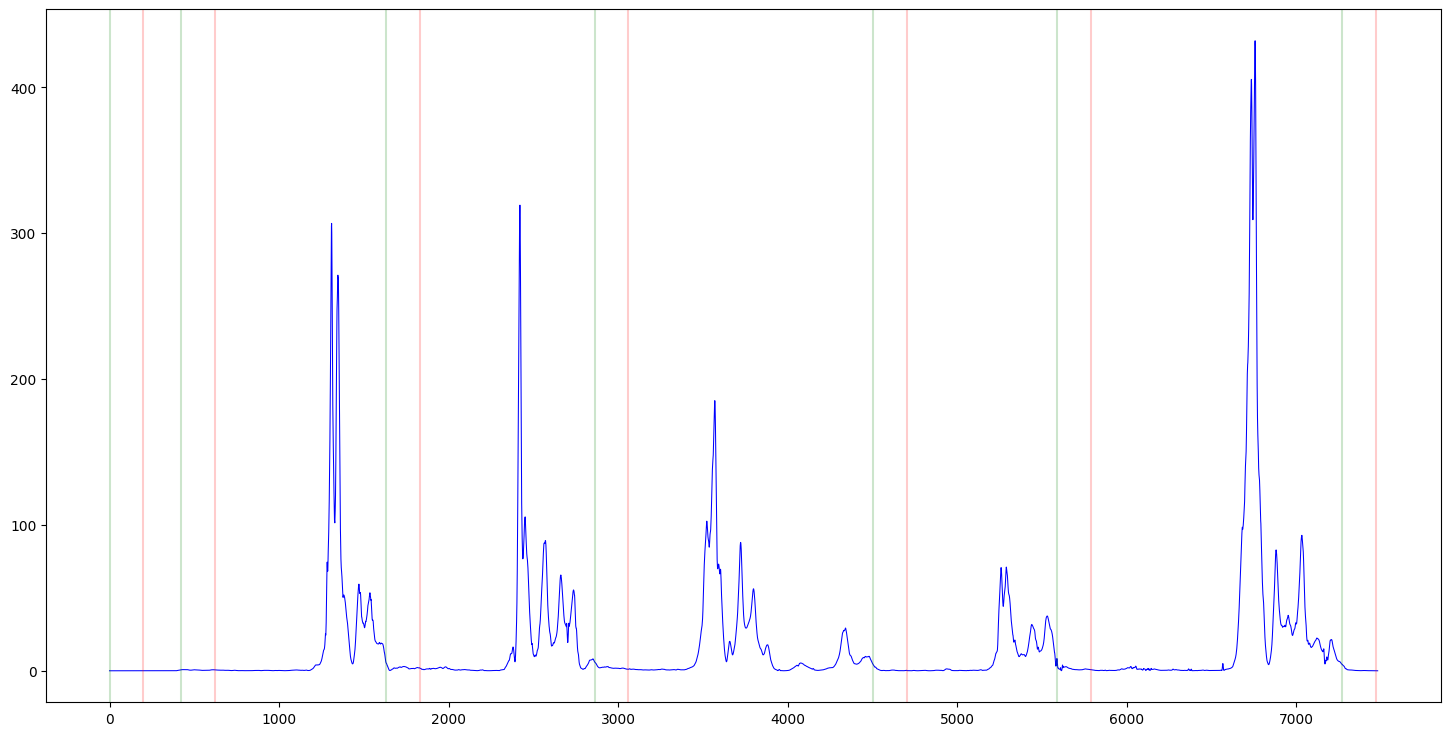

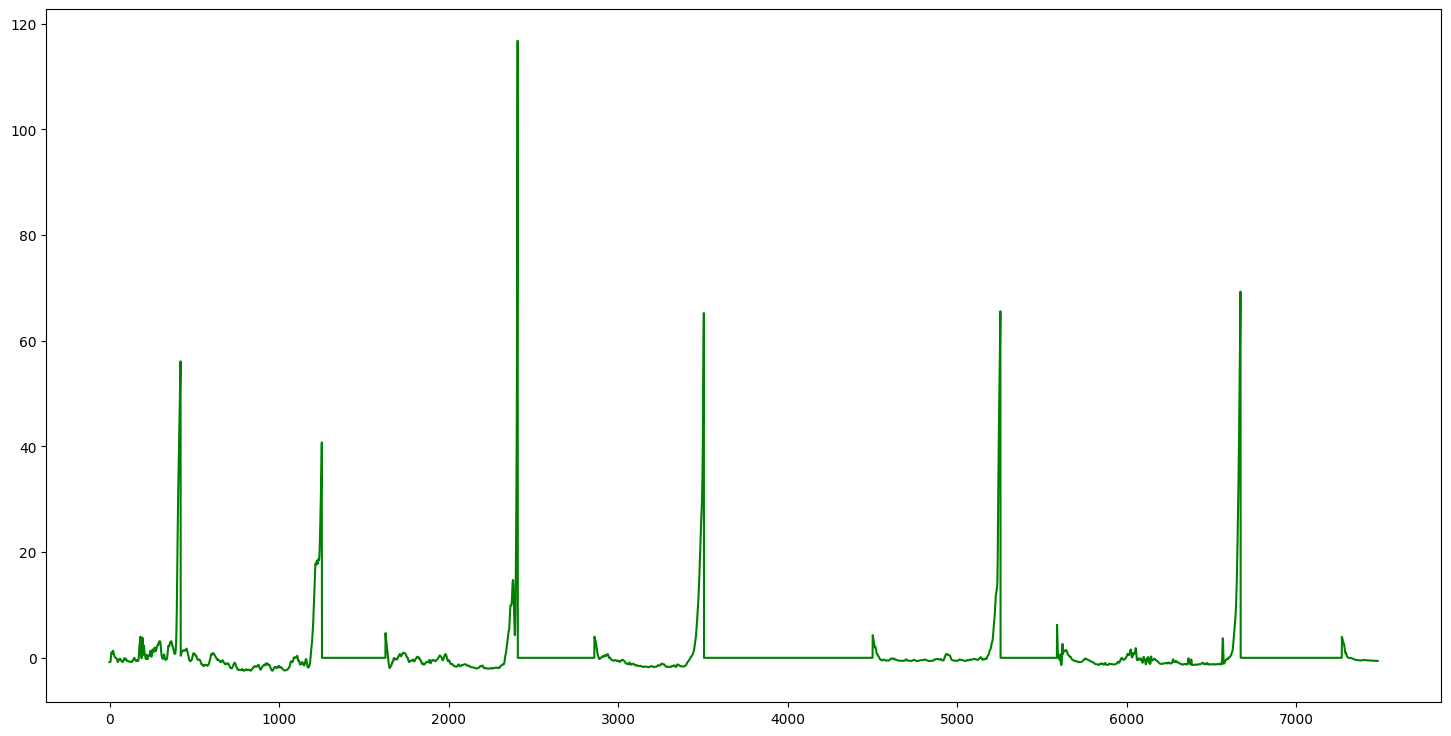

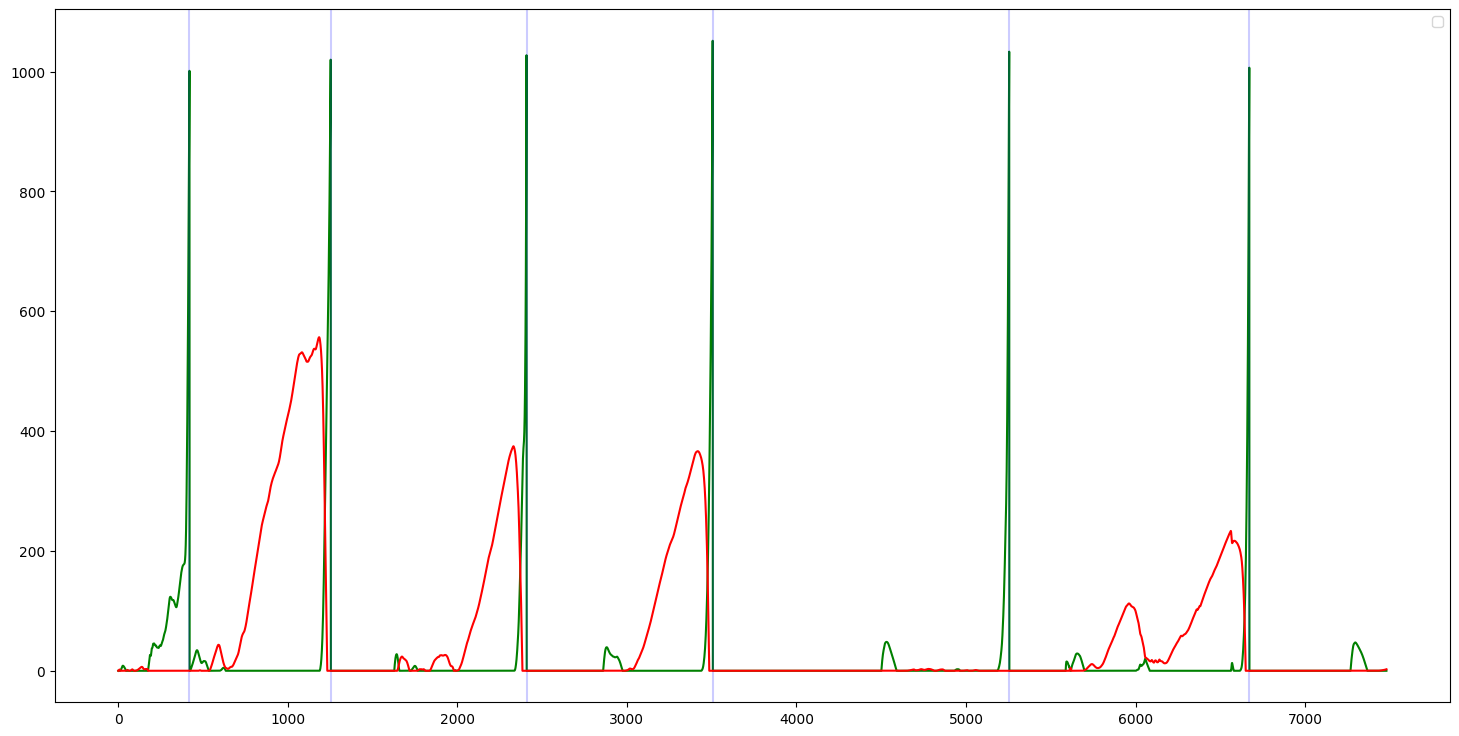

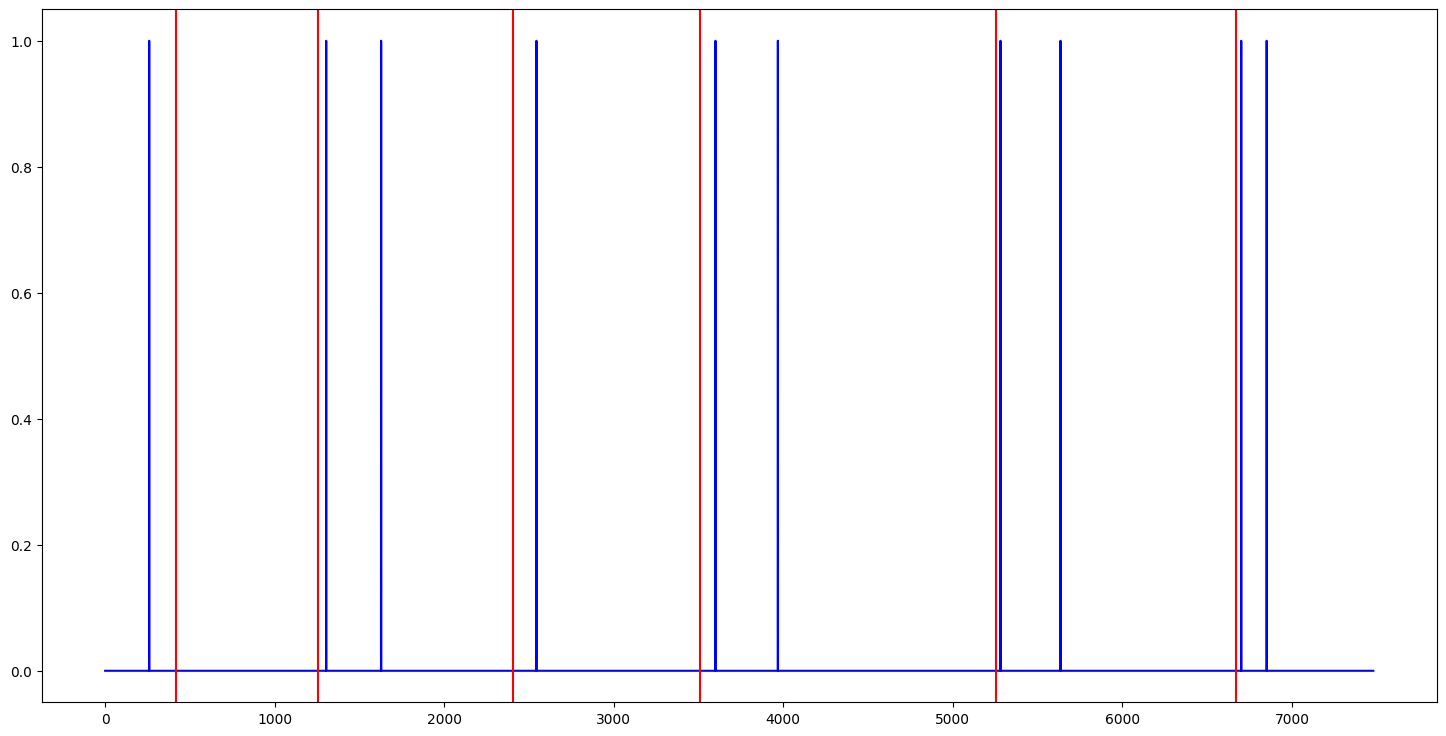

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


df=pd.read_csv("2016-03-22_t024_only_chest.txt",sep=' ', header=None)
df=df.iloc[:,1].values
cp = ChangePointDynWin(df,1000,200,0.5)

gt=pd.read_csv("GA_single_22-03-2016_t024_location_ground_truth.txt", header=None)
gt=gt.values.flatten()

# determino la posizione relativa dei groundtruth per poi allungare il array
#calcolo la lunghezza del nuovo array 
stretch_df = [0] * len(df)
#calcolo la posizione relativa dei uno in gt

for idx,i in enumerate(gt):
    if i==1:
        relpos = idx*(100/len(gt))
        stretch_df[int(np.floor((len(stretch_df)/100)*relpos))]=1




plt.figure(figsize=(18,9))
#plt.plot(np.arange(len(gt)),gt,'g')
plt.plot(np.arange(len(stretch_df)),stretch_df,'blue')
for j in cp:
    plt.axvline(x = j, color = 'red')


C:\Users\tikyn\AppData\Local\Temp\ipykernel_17848\2381946499.py:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  prob = float(self._get_prob(standardized_sum).detach().numpy())


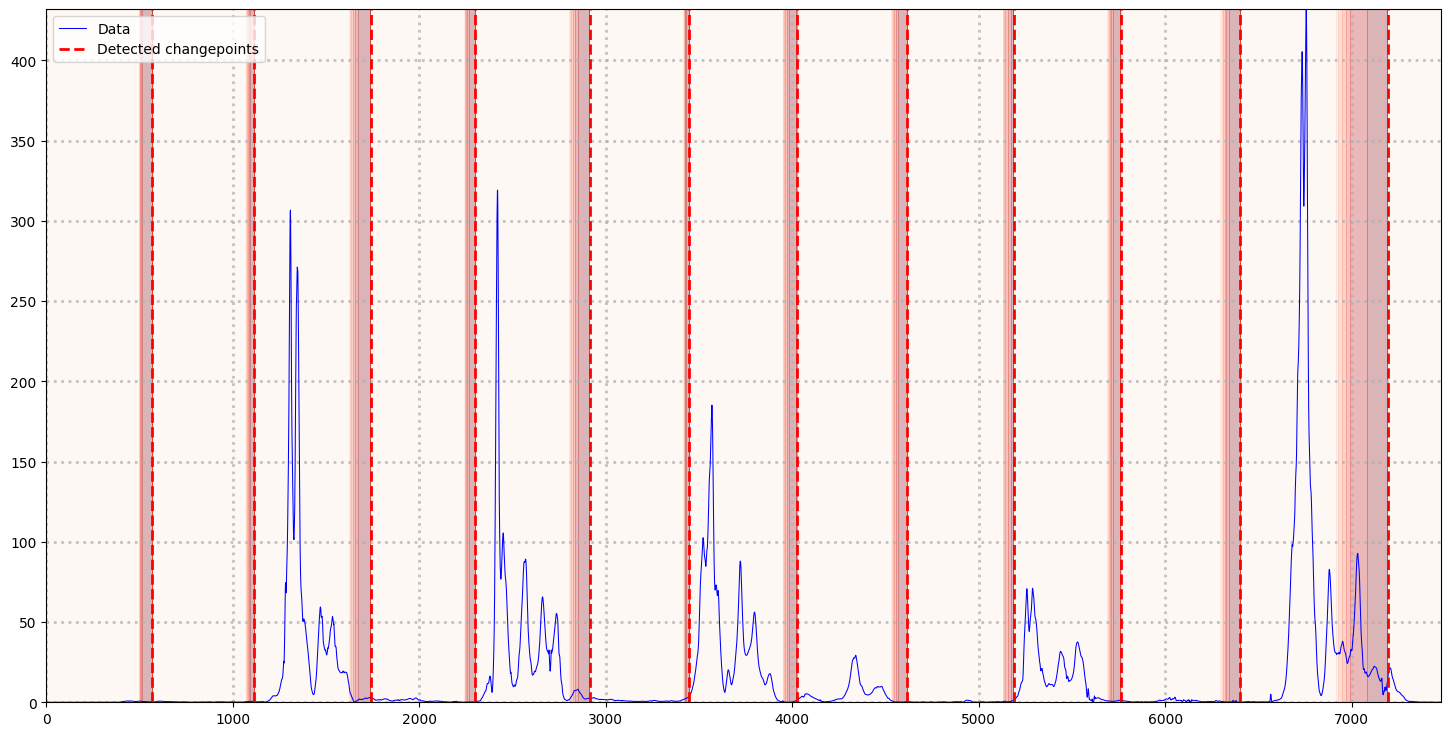

In [15]:
import matplotlib.pyplot as plt

import pandas as pd

import pandas as pd
#df=pd.read_csv("/content/test.csv", header=None, squeeze=True)

#y = torch.tensor(df.T.values)

df=pd.read_csv("2016-03-22_t024_only_chest.txt",sep=' ', header=None)
df=df.iloc[:,1].values
y = torch.tensor(df)

np.random.seed(456)
torch.manual_seed(456)

#segment_lengths = [np.random.randint(30,100) for _ in range(7)]
#y = torch.concat([torch.normal(torch.zeros(seg_len)+np.random.uniform(-5,5),np.random.uniform()+1) for seg_len in segment_lengths])

test = CusumMeanDetector(500,0.001)
#outs = [test.predict_next(y[i][0]) for i in range(len(y))]

outs = [test.predict_next(y[i]) for i in range(len(y))]

cps = np.where(list(map(lambda x: x[1], outs)))[0]
probs = np.array(list(map(lambda x: x[0], outs)))

X, Y = np.meshgrid(np.arange(len(y)),np.linspace(torch.min(y).detach().numpy(),torch.max(y).detach().numpy()))
Z = probs[X]
#


plt.figure(figsize=(18,9))
plt.contourf(X,Y,Z,alpha=0.3,cmap="Reds")
plt.plot(np.arange(len(y)),y.detach().numpy(),lw=0.75,label="Data",color="blue")


plt.axvline(cps[0], color="red", linestyle="dashed",label="Detected changepoints",lw=2)
[plt.axvline(cp, color="red", linestyle="dashed",lw=2) for cp in cps[1:]]

plt.grid(alpha=0.75, linestyle="dotted",lw=2)

plt.legend()
plt.show()

In [3]:
import pandas as pd
df=pd.read_csv("cora_0005.txt",sep=' ', header=None)
df.head()

,0,1,2,3,4,5,6,7
0,0.000000,0.141074,0.000000,417.562783,0.000000,0.000000,0.00000,0.000000
1,0.305302,0.141074,0.000000,417.521250,0.000000,0.000000,0.00000,0.000000
2,0.305302,0.036557,0.000000,417.521250,0.000000,0.000000,0.00000,0.000000
3,0.263908,0.036557,0.000697,417.443845,0.009691,0.006032,0.00002,0.000013
4,0.263908,0.036587,0.000697,417.443845,0.009691,0.006032,0.00002,0.000013


In [20]:
import pandas as pd




df=pd.read_csv("cora_0005.txt",sep=' ', header=None)
df["som"]=df.sum(axis=1)

df=df.iloc[:,8].values
df[3]

417.760763

In [30]:
import pandas as pd




df=pd.read_csv("cora_0005_groundtruth.txt",sep=' ', header=None)
df.iloc[:,0].values

array([  2.94 ,   4.65 ,   9.83 ,  14.72 ,  19.749,  24.23 ,  25.45 ,
        39.37 ,  50.247,  55.656,  57.457,  64.1  ,  69.623,  76.58 ,
        83.46 ,  85.426, 100.575])

C:\Users\tikyn\AppData\Local\Temp\ipykernel_16584\2381946499.py:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  prob = float(self._get_prob(standardized_sum).detach().numpy())


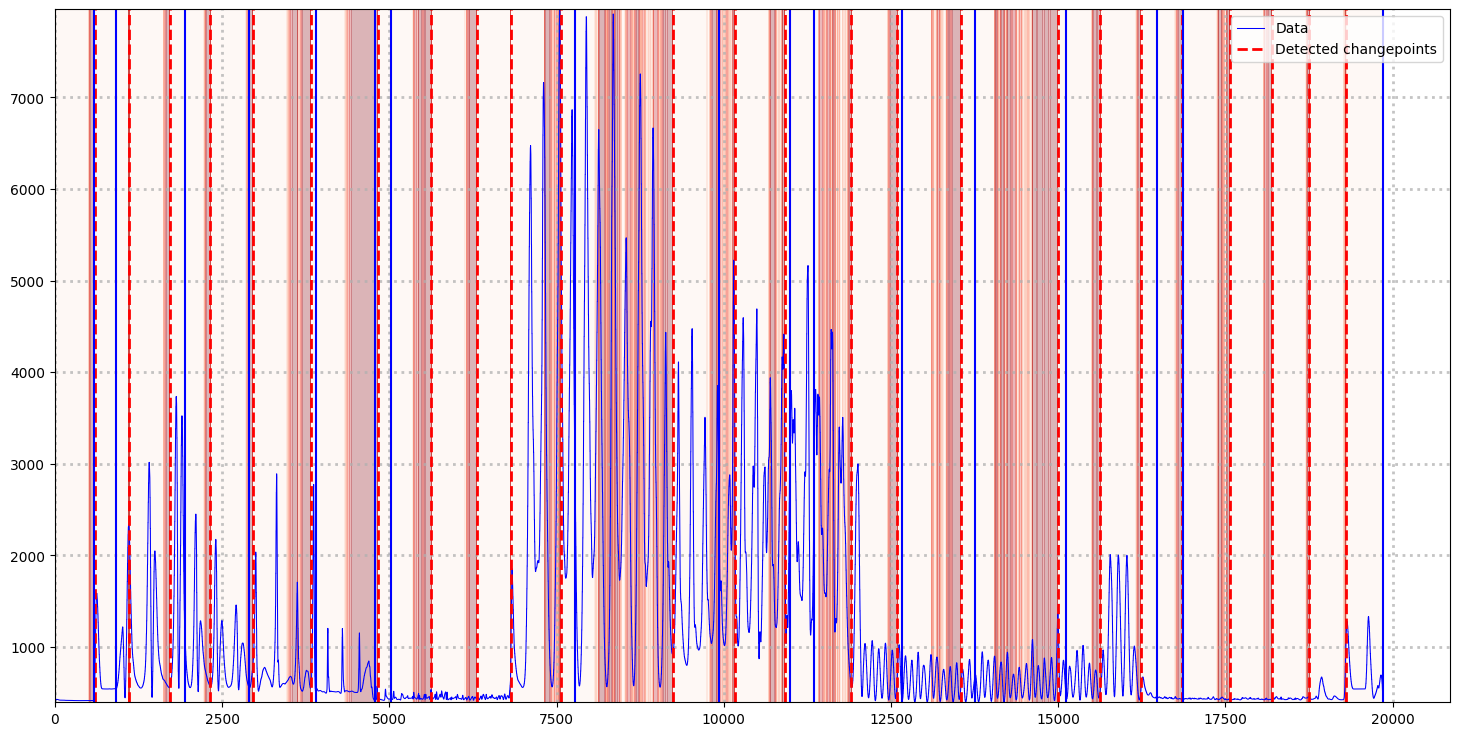

In [52]:
import matplotlib.pyplot as plt

import pandas as pd




df=pd.read_csv("cora_0005.txt",sep=' ', header=None)
df["som"]=df.sum(axis=1)

df=df.iloc[:,8].values
y = torch.tensor(df)

np.random.seed(456)
torch.manual_seed(456)

#segment_lengths = [np.random.randint(30,100) for _ in range(7)]
#y = torch.concat([torch.normal(torch.zeros(seg_len)+np.random.uniform(-5,5),np.random.uniform()+1) for seg_len in segment_lengths])

test = CusumMeanDetector(500,0.001)
#outs = [test.predict_next(y[i][0]) for i in range(len(y))]

outs = [test.predict_next(y[i]) for i in range(len(y))]

cps = np.where(list(map(lambda x: x[1], outs)))[0]
probs = np.array(list(map(lambda x: x[0], outs)))

X, Y = np.meshgrid(np.arange(len(y)),np.linspace(torch.min(y).detach().numpy(),torch.max(y).detach().numpy()))
Z = probs[X]
#


plt.figure(figsize=(18,9))
plt.contourf(X,Y,Z,alpha=0.3,cmap="Reds")
plt.plot(np.arange(len(y)),y.detach().numpy(),lw=0.75,label="Data",color="blue")


plt.axvline(cps[0], color="red", linestyle="dashed",label="Detected changepoints",lw=2)
[plt.axvline(cp, color="red", linestyle="dashed",lw=2) for cp in cps[1:]]

gt=pd.read_csv("cora_0005_groundtruth.txt",sep=' ', header=None)
gt=gt.iloc[:,0].values

# determino la posizione relativa dei groundtruth per poi allungare il array
#calcolo la lunghezza del nuovo array 
stretch_df = []
#calcolo la posizione relativa dei uno in gt

for idx,i in enumerate(gt):

    relpos = len(df)*i/gt[-1]
    stretch_df.append(relpos)

#plt.plot(np.arange(len(stretch_df)),stretch_df,'blue')
for j in stretch_df:
    plt.axvline(x = j, color = 'blue')

plt.grid(alpha=0.75, linestyle="dotted",lw=2)

plt.legend()
plt.show()

Std init: 3.5042855047752974
std: 0.9887045050725539


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


std: 0.5953762659889825
z
[-0.6631765082591491, -0.6930019890476183, -0.7222079426893934, -0.72219938174309, -0.713426409347427, -0.7134823408632095, -0.7439279195281082, -0.7439621633132891, -0.7742136938622601, -0.7743309788264634, -0.7287482202919783, -0.7288395370524444, -0.5210733607497691, -0.5211698140779978, -0.09008907081624119, -0.09021406063212069, 0.5533799036515423, 0.5532700381741235, 1.291158830761447, 1.2910472530947739, 1.9623079128767795, 1.9622068937105397, 2.3991904094409855, 2.3991281998979215, 2.520966160708537, 2.5209048072601163, 2.3821478482916207, 2.382063094923328, 2.1700740891794386, 2.1700115942715152, 2.1909693615253305, 2.190943678686453, 2.1714481210593886, 2.1714384186535827, 2.1195693572565473, 2.119557942661487, 2.0906721684110385, 2.090690431763132, 2.038400171808498, 2.0384258546473757, 1.976656058863021, 1.976636654051425, 1.872150589916224, 1.8721500191864726, 1.7499045573323406, 1.7498620379657484, 1.616258197935622, 1.616267900341412, 1.46166462

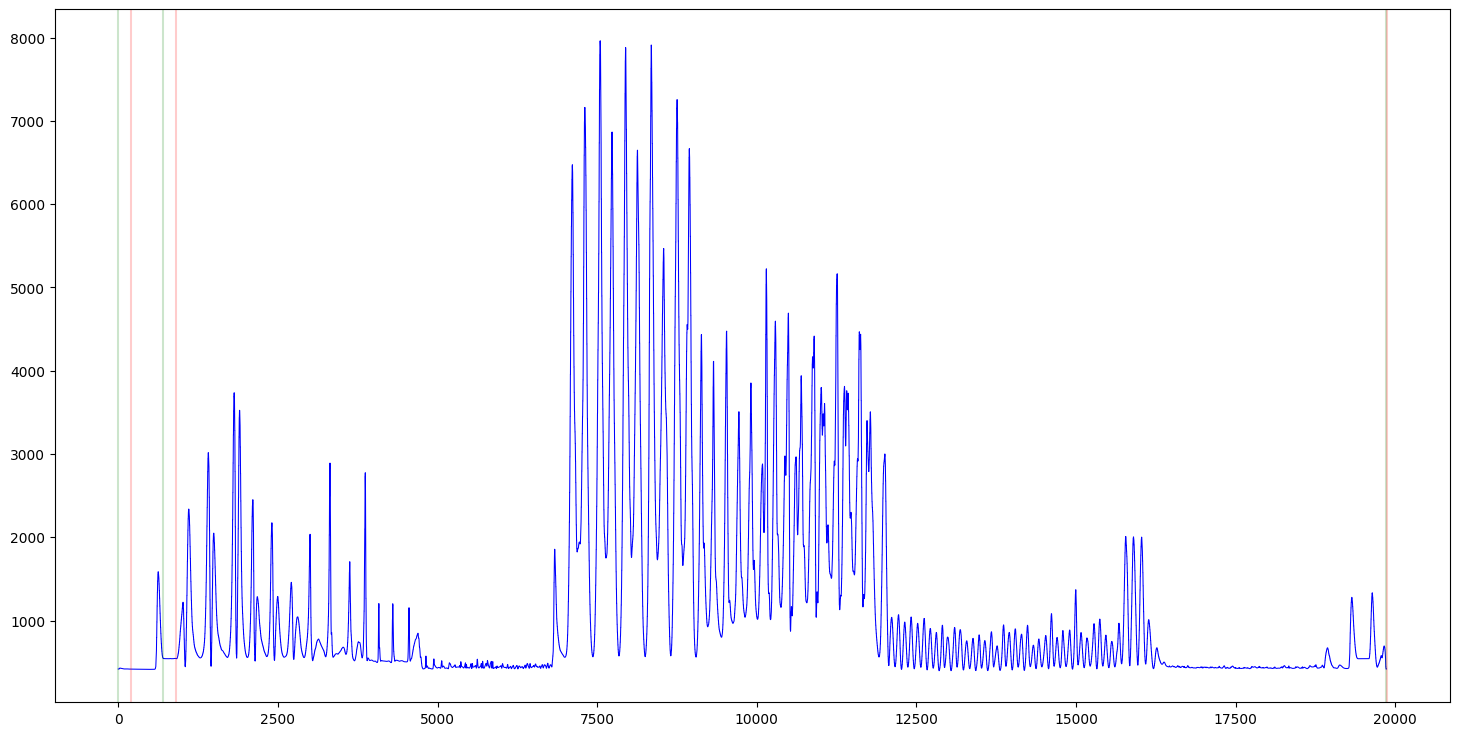

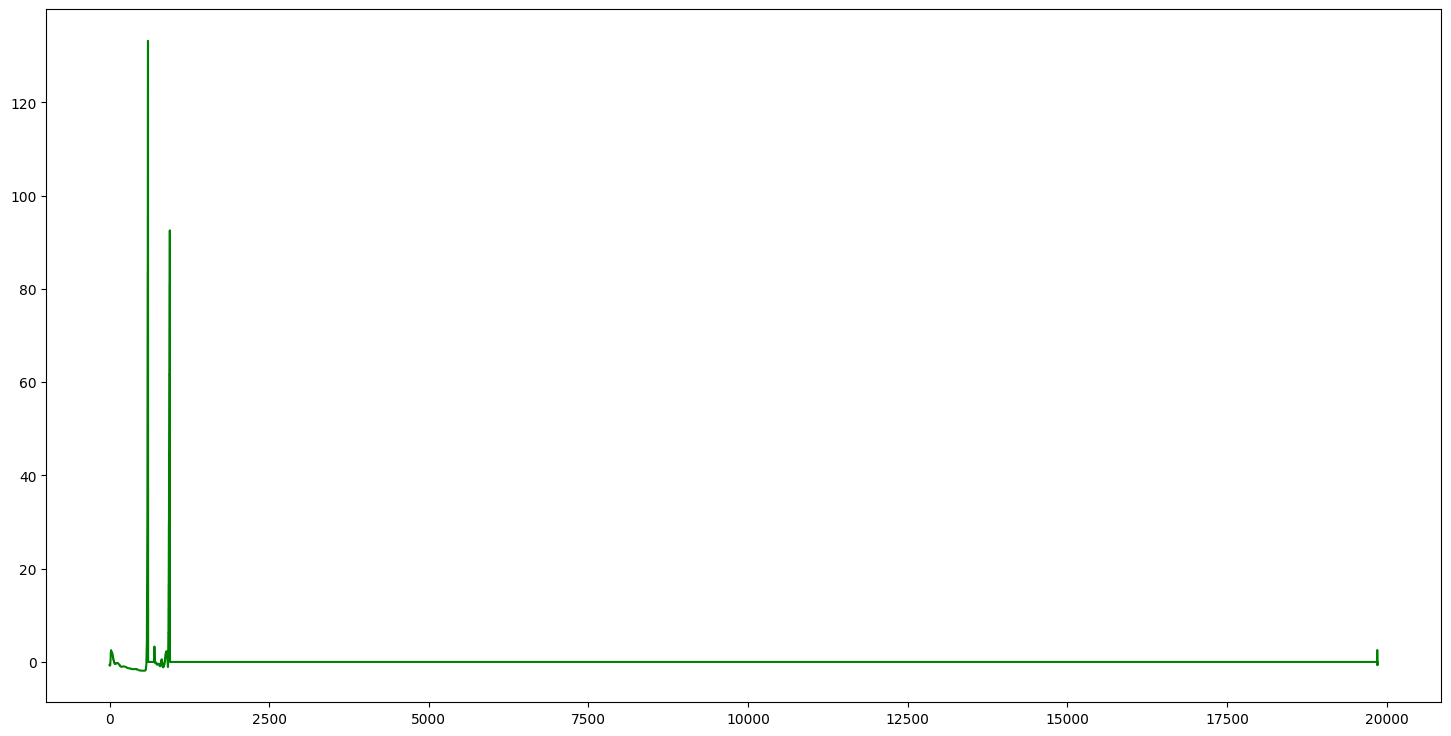

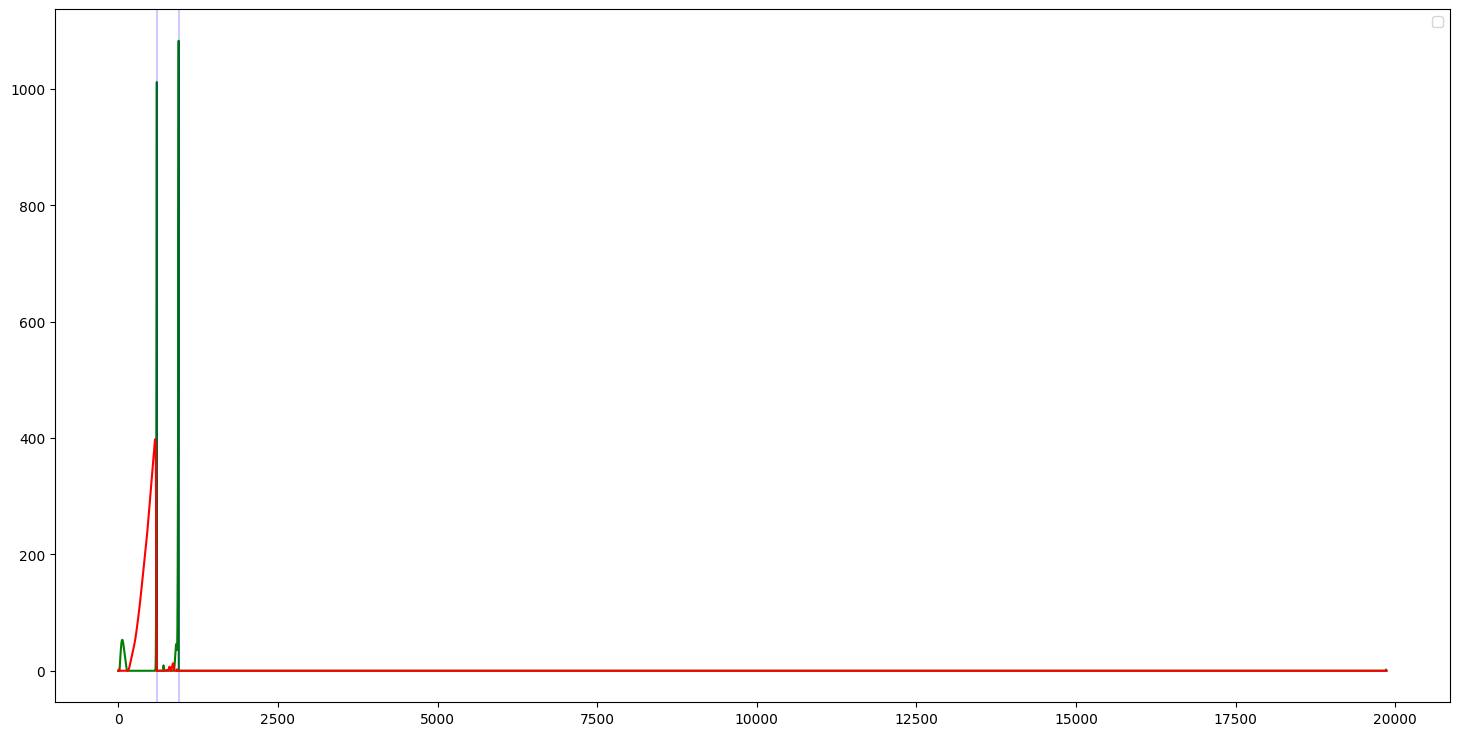

C:\Users\tikyn\AppData\Local\Temp\ipykernel_16584\996552095.py:29: RuntimeWarning: invalid value encountered in scalar divide
  relpos = len(df)*i/gt[-1]
C:\Users\tikyn\AppData\Local\Temp\ipykernel_16584\996552095.py:29: RuntimeWarning: divide by zero encountered in scalar divide
  relpos = len(df)*i/gt[-1]


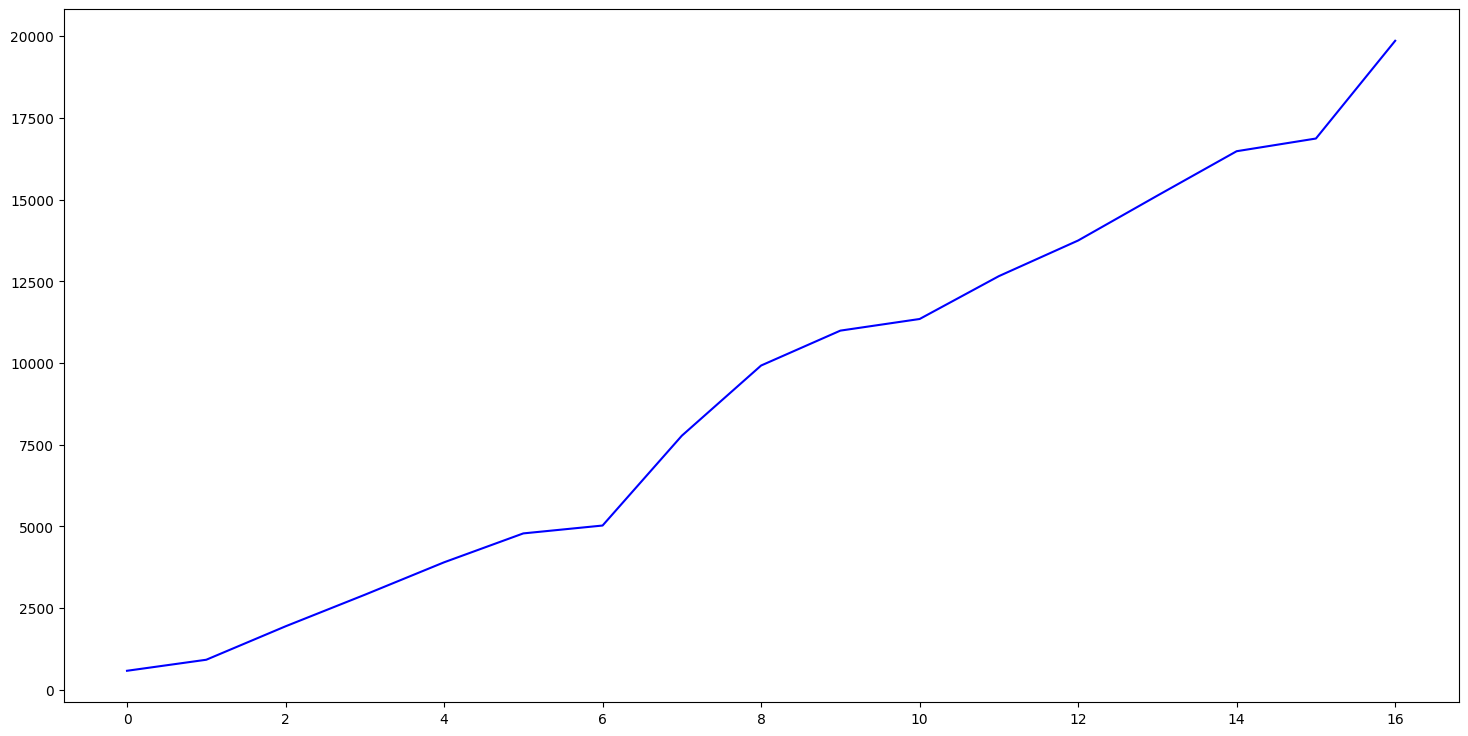

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np



df=pd.read_csv("cora_0005.txt",sep=' ', header=None)
df["som"]=df.sum(axis=1)

df=df.iloc[:,8].values
cp = ChangePointDynWin(df,1000,200,0.5)

gt=pd.read_csv("GA_single_22-03-2016_t024_location_ground_truth.txt", header=None)
gt=gt.values.flatten()






plt.figure(figsize=(18,9))
#plt.plot(np.arange(len(gt)),gt,'g')
plt.plot(np.arange(len(stretch_df)),stretch_df,'blue')
stretch_df = []
#calcolo la posizione relativa dei uno in gt

for idx,i in enumerate(gt):

    relpos = len(df)*i/gt[-1]
    stretch_df.append(relpos)

#plt.plot(np.arange(len(stretch_df)),stretch_df,'blue')
for j in stretch_df:
    plt.axvline(x = j, color = 'blue')

Questo per vedere le varie feature

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

colors=['g','r','c','m','y','k','w']

df=pd.read_csv("cora_0005.txt",sep=' ', header=None)
df["som"]=df.sum(axis=1)
#df=df.iloc[:,8].values



#plt.plot(np.arange(len(gt)),gt,'g')

 
for index,idx in enumerate(range(0,8)):
    plt.figure(figsize=(18,9))
    plt.plot(np.arange(len(df.iloc[:,8].values)),df.iloc[:,8].values,'blue') 
    plt.plot(np.arange(len(df.iloc[:,idx].values)),df.iloc[:,idx].values,colors[index%len(colors)]) 

Lavoro sul smoothing dei dati

Inizio con il moving average

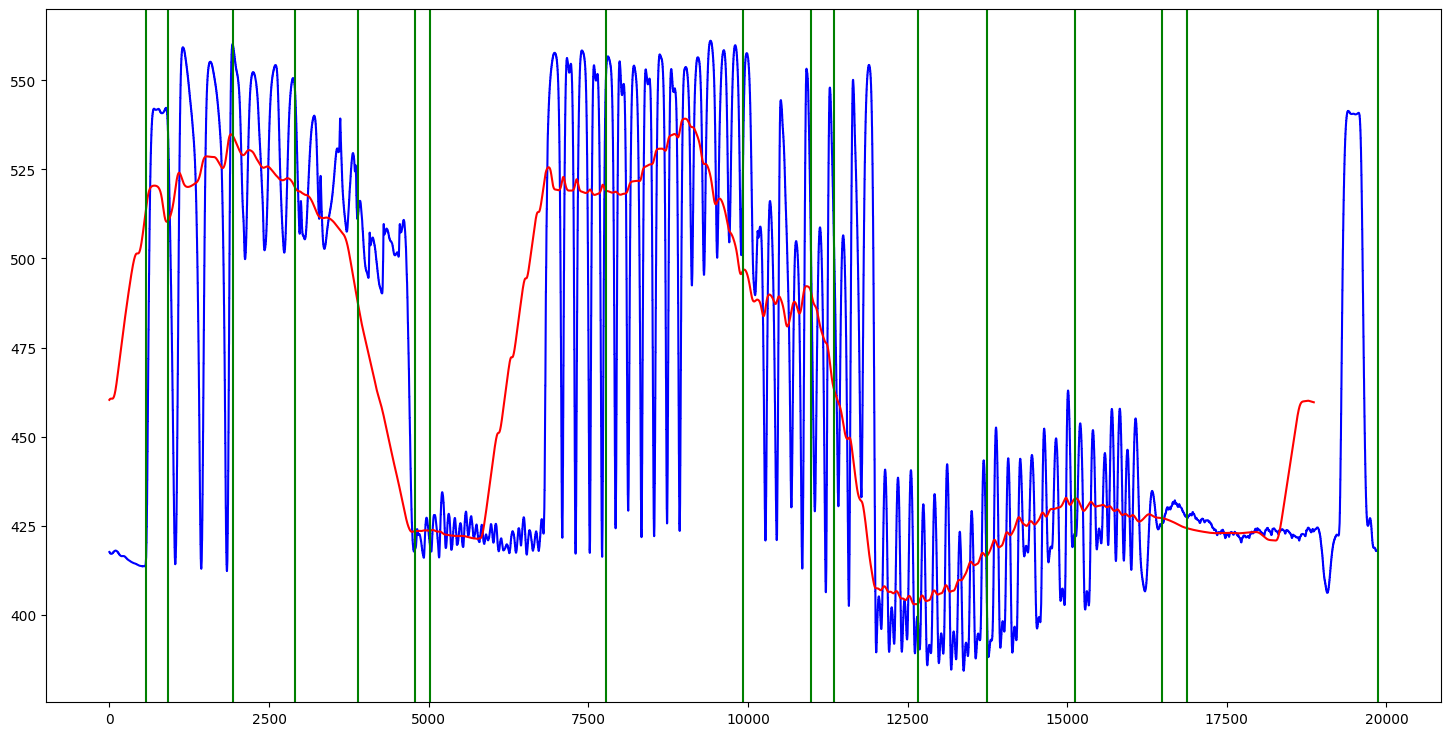

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

feat=df.iloc[:,3]

df=pd.read_csv("cora_0005.txt",sep=' ', header=None)
df["som"]=df.sum(axis=1)

#df=df.iloc[:,8].values
window_size = 1000
#myseries = pd.Series(df["som"])
myseries = pd.Series(feat)
my_win = myseries.rolling(window_size)
mov_avg = my_win.mean()
mov_avg_list = mov_avg.tolist()
final_list = mov_avg_list[window_size-1:]



plt.figure(figsize=(18,9))
plt.plot(np.arange(len(feat.values)),feat.values,'blue') 
plt.plot(np.arange(len(final_list)),final_list,'red') 

gt=pd.read_csv("cora_0005_groundtruth.txt",sep=' ', header=None)
gt=gt.iloc[:,0].values

# determino la posizione relativa dei groundtruth per poi allungare il array
#calcolo la lunghezza del nuovo array 
stretch_df = []
#calcolo la posizione relativa dei uno in gt

for idx,i in enumerate(gt):

    relpos = len(df)*i/gt[-1]
    stretch_df.append(relpos)

#plt.plot(np.arange(len(stretch_df)),stretch_df,'blue')
for j in stretch_df:
    plt.axvline(x = j, color = 'green')

Procedo con il savgol filter

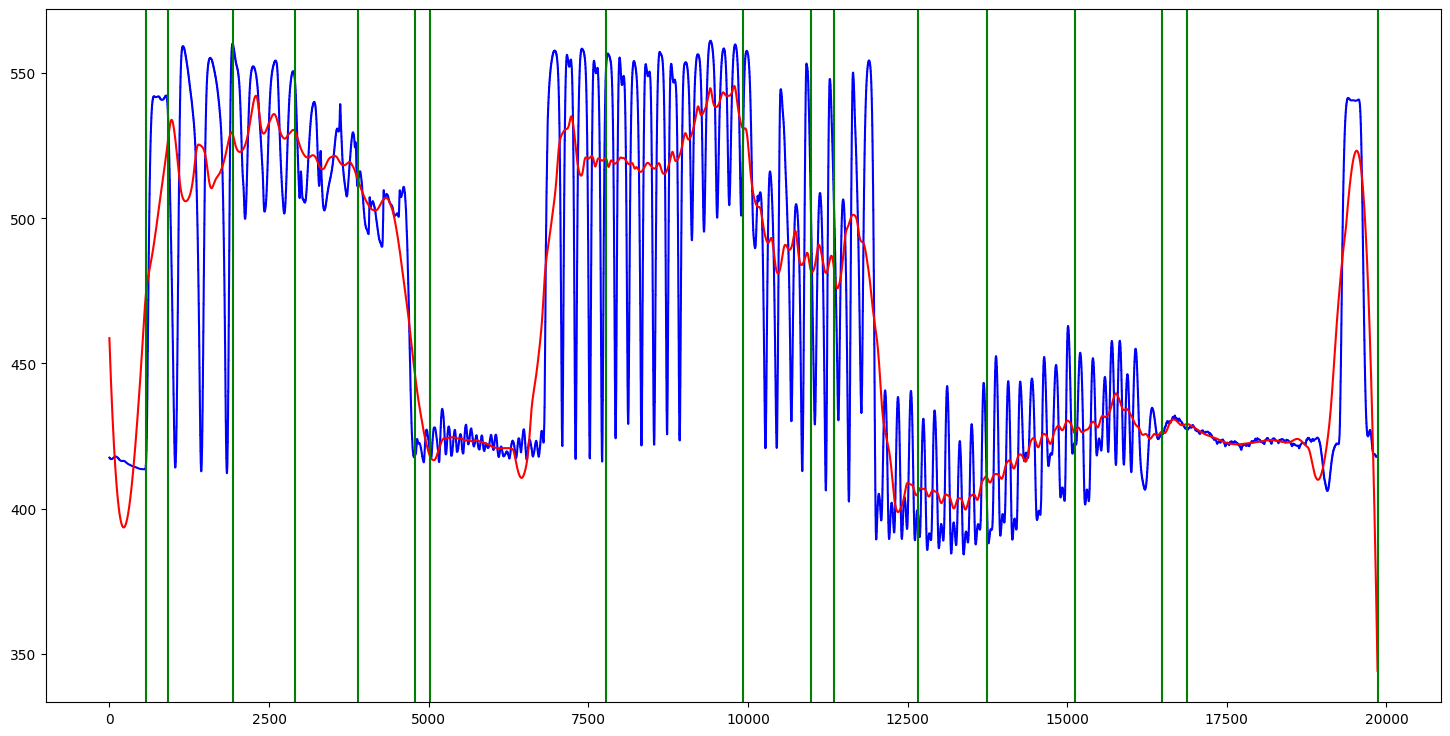

In [31]:
from scipy.signal import savgol_filter
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

feat=df.iloc[:,3]

df=pd.read_csv("cora_0005.txt",sep=' ', header=None)
df["som"]=df.sum(axis=1)


final_list = savgol_filter(feat.values,1000,3)



plt.figure(figsize=(18,9))
plt.plot(np.arange(len(feat.values)),feat.values,'blue') 
plt.plot(np.arange(len(final_list)),final_list,'red') 

gt=pd.read_csv("cora_0005_groundtruth.txt",sep=' ', header=None)
gt=gt.iloc[:,0].values

# determino la posizione relativa dei groundtruth per poi allungare il array
#calcolo la lunghezza del nuovo array 
stretch_df = []
#calcolo la posizione relativa dei uno in gt

for idx,i in enumerate(gt):

    relpos = len(df)*i/gt[-1]
    stretch_df.append(relpos)

#plt.plot(np.arange(len(stretch_df)),stretch_df,'blue')
for j in stretch_df:
    plt.axvline(x = j, color = 'green')

Uso PAA - Piecewise Aggregate Approximation

[array([0.141074, 0.141074, 0.036557, ..., 0.007635, 0.007635, 0.007635]), array([    0,     1,     2, ..., 19859, 19860, 19861])]


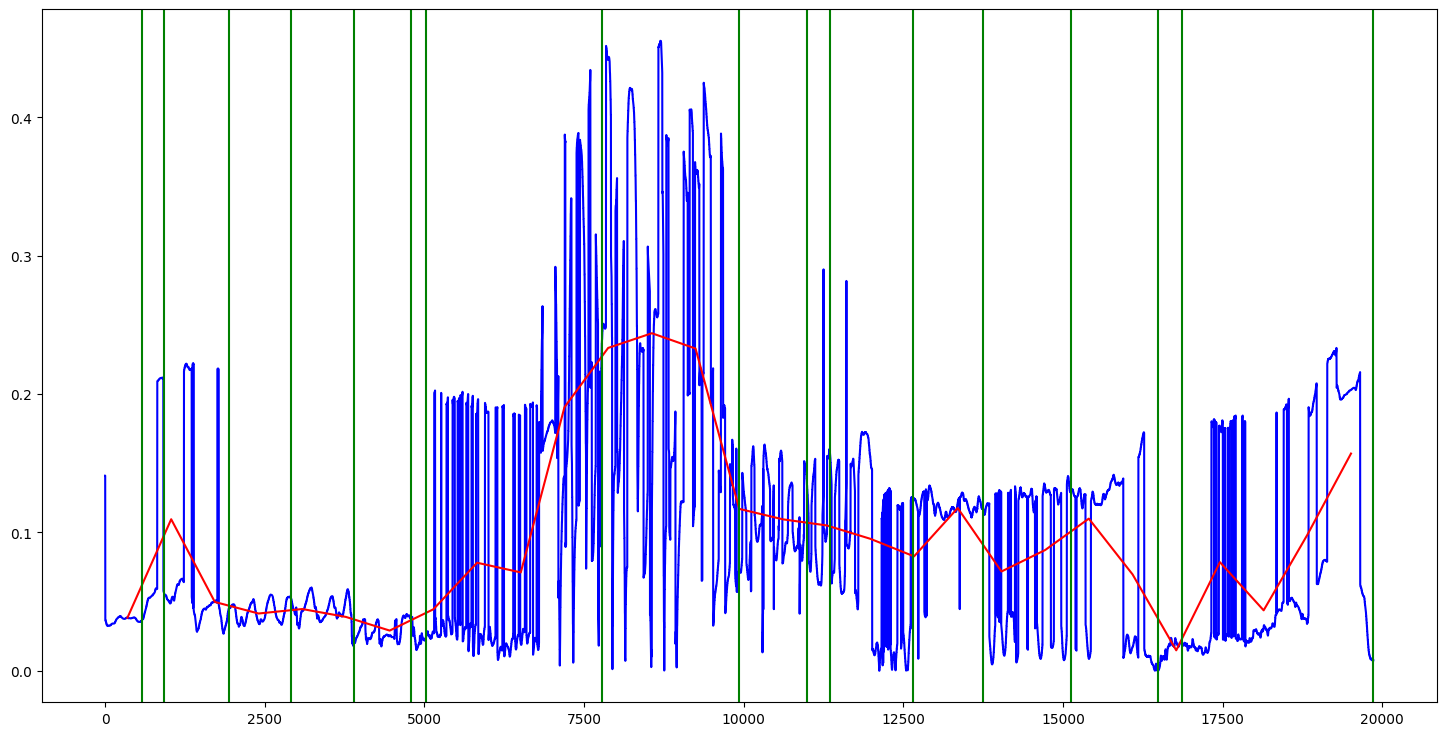

In [63]:
from pyts.approximation import PiecewiseAggregateApproximation
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

feat=df.iloc[:,1]

df=pd.read_csv("cora_0005.txt",sep=' ', header=None)
df["som"]=df.sum(axis=1)

window_size = 700
paa = PiecewiseAggregateApproximation(window_size=window_size)
print([feat.values,np.arange(len(feat.values))])
final_list = X_paa = paa.transform([feat.values,np.arange(len(feat.values))])



plt.figure(figsize=(18,9))
plt.plot(np.arange(len(feat.values)),feat.values,'blue') 
plt.plot(final_list[1],final_list[0],'red') 

gt=pd.read_csv("cora_0005_groundtruth.txt",sep=' ', header=None)
gt=gt.iloc[:,0].values

# determino la posizione relativa dei groundtruth per poi allungare il array
#calcolo la lunghezza del nuovo array 
stretch_df = []
#calcolo la posizione relativa dei uno in gt

for idx,i in enumerate(gt):

    relpos = len(df)*i/gt[-1]
    stretch_df.append(relpos)

#plt.plot(np.arange(len(stretch_df)),stretch_df,'blue')
for j in stretch_df:
    plt.axvline(x = j, color = 'green')

Provo con mean filter

In [19]:
x=np.array([1])
x = np.append(x,[0]*3)
x.flatten()
x

1.5

In [33]:
def MeanFilter(ts,win):
    
    result=np.array([])
    for i in range(0,len(ts)-win,win):
        result = np.append(result,[np.mean(ts[i:i+win])]*win)
        result.flatten()
    return result


def MedianFilter(ts,win):
    
    result=np.array([])
    for i in range(0,len(ts)-win,win):
        result = np.append(result,[np.median(ts[i:i+win])]*win)
        result.flatten()
    return result


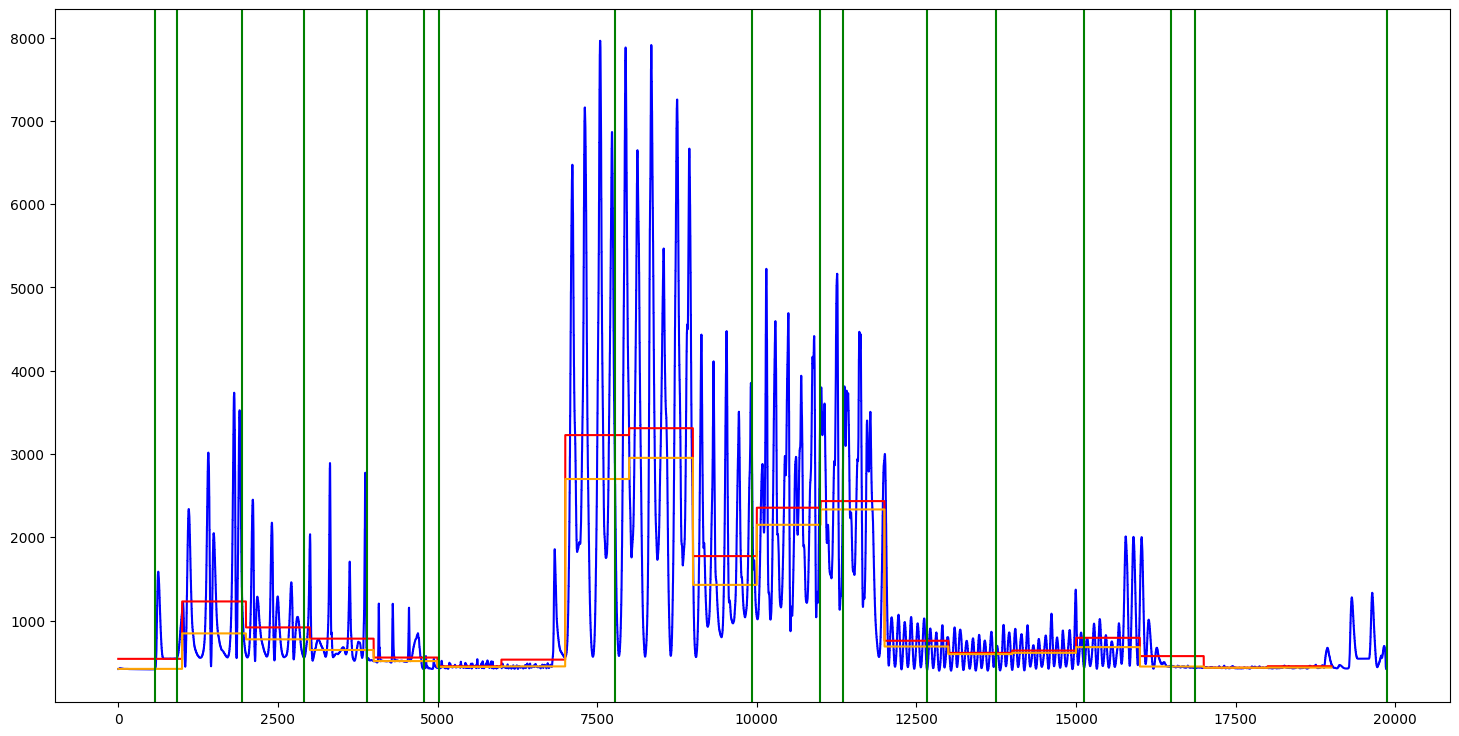

In [39]:
from scipy.ndimage import uniform_filter1d
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np



df=pd.read_csv("cora_0005.txt",sep=' ', header=None)
df["som"]=df.sum(axis=1)


feat=df.iloc[:,8]

final_list = MeanFilter(feat.values,1000)
median_list = MedianFilter(feat.values,1000)

plt.figure(figsize=(18,9))
plt.plot(np.arange(len(feat.values)),feat.values,'blue') 
plt.plot(np.arange(len(final_list)),final_list,'red') 
plt.plot(np.arange(len(median_list)),median_list,'orange') 

gt=pd.read_csv("cora_0005_groundtruth.txt",sep=' ', header=None)
gt=gt.iloc[:,0].values

# determino la posizione relativa dei groundtruth per poi allungare il array
#calcolo la lunghezza del nuovo array 
stretch_df = []
#calcolo la posizione relativa dei uno in gt

for idx,i in enumerate(gt):

    relpos = len(df)*i/gt[-1]
    stretch_df.append(relpos)

#plt.plot(np.arange(len(stretch_df)),stretch_df,'blue')
for j in stretch_df:
    plt.axvline(x = j, color = 'green')